# Random Forest (Ensemble Model)

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
from sklearn.model_selection import TimeSeriesSplit

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

### (Part0) Data Preparation & Helper Function

We will use Apple Stock Price data from 2021-12-29 to 2021-4-28 (4month). We will include all the technical features we produced to perform feature selection. 

In [2]:
def prepare_dataset(path = 'data/AAPL_data.csv', s_path = 'data/AAPL_byday_RoBERTa.csv', start_date = '2021-12-29', sentiment = False):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index = df['Date']
    df = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    if sentiment:
        df.index = np.array(range(len(df)))
        df_sentiment = pd.read_csv(s_path)
        df_sentiment.date = df_sentiment.date.apply(convert)
        df_sentiment.rename(columns={'date':'Date'}, inplace=True)
        df = df.merge(df_sentiment, how='inner', on='Date').fillna(0)

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)
    cols = X.columns
    
    X = np.array(X)
    X = X.astype(np.float32)

    # Split training and validation data
    split = int(0.8 * len(X))
    X_train = X[:split]
    y_train = y[:split]

    return X_train, y_train, cols

In [3]:
def convert(date_string):
    year, month, day = [int(i) for i in date_string.split('-')]
    return datetime(year=year, month=month, day=day)

In [4]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    Run random forest and return model and accuracy score. 
    '''
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [5]:
def adaboost(X_train, X_test, y_train, y_test):
    '''
    Run adaboost and return model and accuracy score. 
    '''   
    model = AdaBoostClassifier(random_state=42, n_estimators=100, algorithm='SAMME')
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [6]:
def gradient_boost(X_train, X_test, y_train, y_test):
    '''
    Run gradient boosting and return model and accuracy score. 
    '''       
    model = GradientBoostingClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [7]:
def sklearn_cross_validation(df_X, df_y, split, verbose, plot = False):
    '''
    Do cross validation based on ScikitLearn's Time Series Split
    '''
    tscv = TimeSeriesSplit(n_splits=split)

    rf_results = []
    ada_results = []
    gradient_results = []
    rf_feature_imp = np.zeros(df_X.shape[1])
    ada_feature_imp = np.zeros(df_X.shape[1])
    gra_feature_imp = np.zeros(df_X.shape[1])

    for train_index, validation_index in tscv.split(df_X):
        #print("TRAIN:", train_index, "VALIDATION:", validation_index)
        X_train, X_validation = df_X[train_index], df_X[validation_index]
        y_train, y_validation = df_y[train_index], df_y[validation_index]

        t_scaler = MinMaxScaler()
        X_train = t_scaler.fit_transform(X_train)
        X_validation = t_scaler.transform(X_validation)

        if len(np.unique(y_train)) == 1:
            continue

        rf, rf_accuracy, rf_imp = random_forest(X_train, X_validation, y_train, y_validation)
        len(rf_imp)
        rf_results.append(rf_accuracy)
        rf_feature_imp = rf_feature_imp + rf_imp
        ada, ada_accuracy, ada_imp = adaboost(X_train, X_validation, y_train, y_validation)
        ada_results.append(ada_accuracy)
        ada_feature_imp = ada_feature_imp + ada_imp
        gra, gra_accuracy, gra_imp = gradient_boost(X_train, X_validation, y_train, y_validation)
        gradient_results.append(gra_accuracy)
        gra_feature_imp = gra_feature_imp + gra_imp

    rf_feature_imp = rf_feature_imp / split
    ada_feature_imp = ada_feature_imp / split
    gra_feature_imp = gra_feature_imp / split

    if verbose:
        print("Mean Accuracy of Random Forests", sum(rf_results)/len(rf_results))
        print("Mean Accuracy of Adaboost", sum(ada_results)/len(ada_results))
        print("Mean Accuracy of Gradient Boosting", sum(gradient_results)/len(gradient_results))
    
    if plot:
        return sum(rf_results)/len(rf_results), sum(ada_results)/len(ada_results), sum(gradient_results)/len(gradient_results)
    return rf_feature_imp, ada_feature_imp, gra_feature_imp

In [8]:
def feature_importance(importances, columns): 
    feature_names = [i for i in columns]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)
    
    print('Top 20 Best Features : \n')
    print(forest_importances.head(20))
    fig, ax = plt.subplots(figsize=(30,20))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

## Apple

In [9]:
# AAPL : Data with full set of technical features
X_train_AAPL, y_train_AAPL, columns_AAPL = prepare_dataset()

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [10]:
rf_AAPL, ada_AAPL, gra_AAPL = sklearn_cross_validation(X_train_AAPL, y_train_AAPL, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.5454545454545455
Mean Accuracy of Adaboost 0.509090909090909
Mean Accuracy of Gradient Boosting 0.5636363636363637


Mean Accuracy of Random Forests 0.4166666666666667
Mean Accuracy of Adaboost 0.4791666666666667
Mean Accuracy of Gradient Boosting 0.5416666666666666
Mean Accuracy of Random Forests 0.5454545454545455
Mean Accuracy of Adaboost 0.509090909090909
Mean Accuracy of Gradient Boosting 0.5636363636363637
Mean Accuracy of Random Forests 0.4833333333333333
Mean Accuracy of Adaboost 0.5
Mean Accuracy of Gradient Boosting 0.39999999999999997


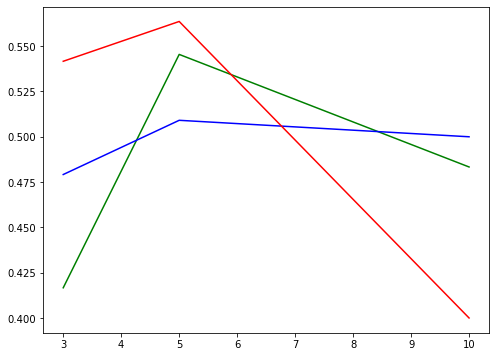

In [11]:
num_folds = [3,5,10]#commonly used k folds
acc_rf = []
acc_ada = []
acc_gb = []

for fold in num_folds:
    rf, ada, gb = sklearn_cross_validation(X_train_AAPL, y_train_AAPL, fold, verbose=True, plot=True)
    acc_rf.append(rf)
    acc_ada.append(ada)
    acc_gb.append(gb)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(num_folds, acc_rf, color = 'Green')
ax.plot(num_folds, acc_ada, color = 'Blue')
ax.plot(num_folds, acc_gb, color = 'Red')

Top 20 Best Features : 

High                     0.032461
volume_nvi               0.023989
Open                     0.023636
volume_vwap              0.021207
trend_vortex_ind_diff    0.020915
momentum_pvo             0.020386
momentum_stoch_rsi_k     0.020207
trend_dpo                0.019764
volume_vpt               0.019516
trend_adx_pos            0.019372
volume_adi               0.018485
volume_em                0.017996
Low                      0.017896
trend_mass_index         0.017721
momentum_pvo_hist        0.017166
trend_sma_fast           0.016392
momentum_stoch           0.015654
momentum_tsi             0.015560
volatility_kch           0.015187
trend_adx                0.014643
dtype: float64


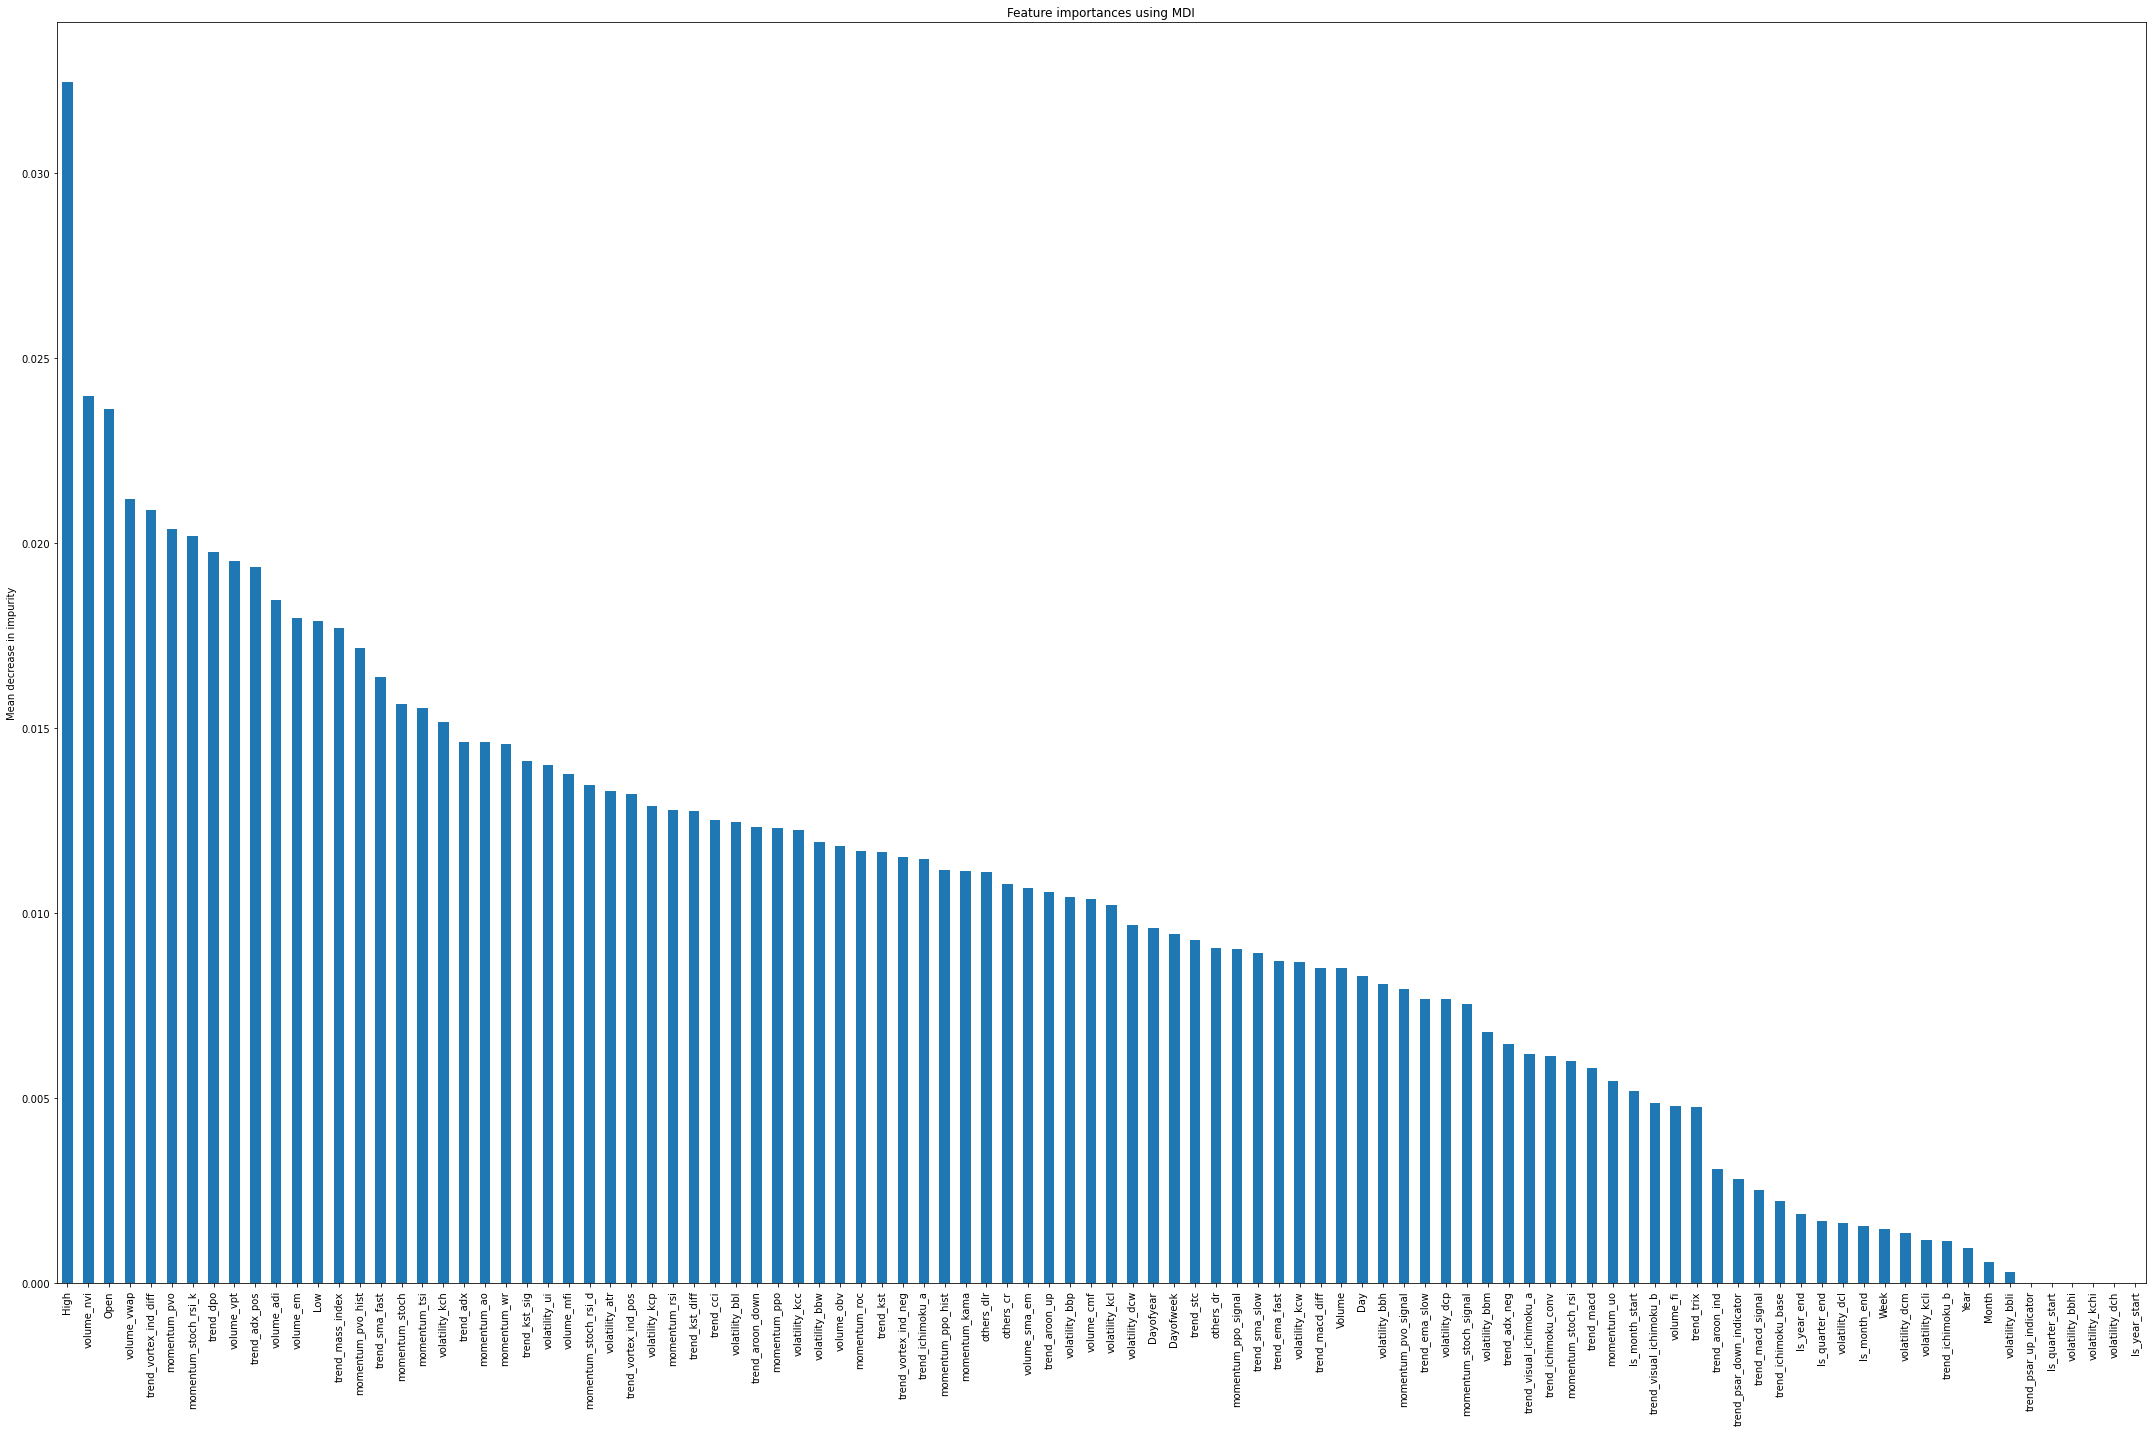

In [12]:
_ = feature_importance(rf_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.094922
momentum_pvo             0.071402
trend_mass_index         0.066193
volume_obv               0.055454
trend_vortex_ind_diff    0.052970
volume_vpt               0.044116
trend_kst_diff           0.040166
momentum_stoch_signal    0.031715
volume_nvi               0.028296
trend_aroon_up           0.024591
momentum_pvo_hist        0.022462
High                     0.022081
trend_kst_sig            0.020492
trend_aroon_down         0.019700
volatility_bbl           0.019185
Dayofweek                0.018423
momentum_ao              0.017595
trend_sma_fast           0.017551
trend_stc                0.016586
volatility_kcl           0.015513
dtype: float64


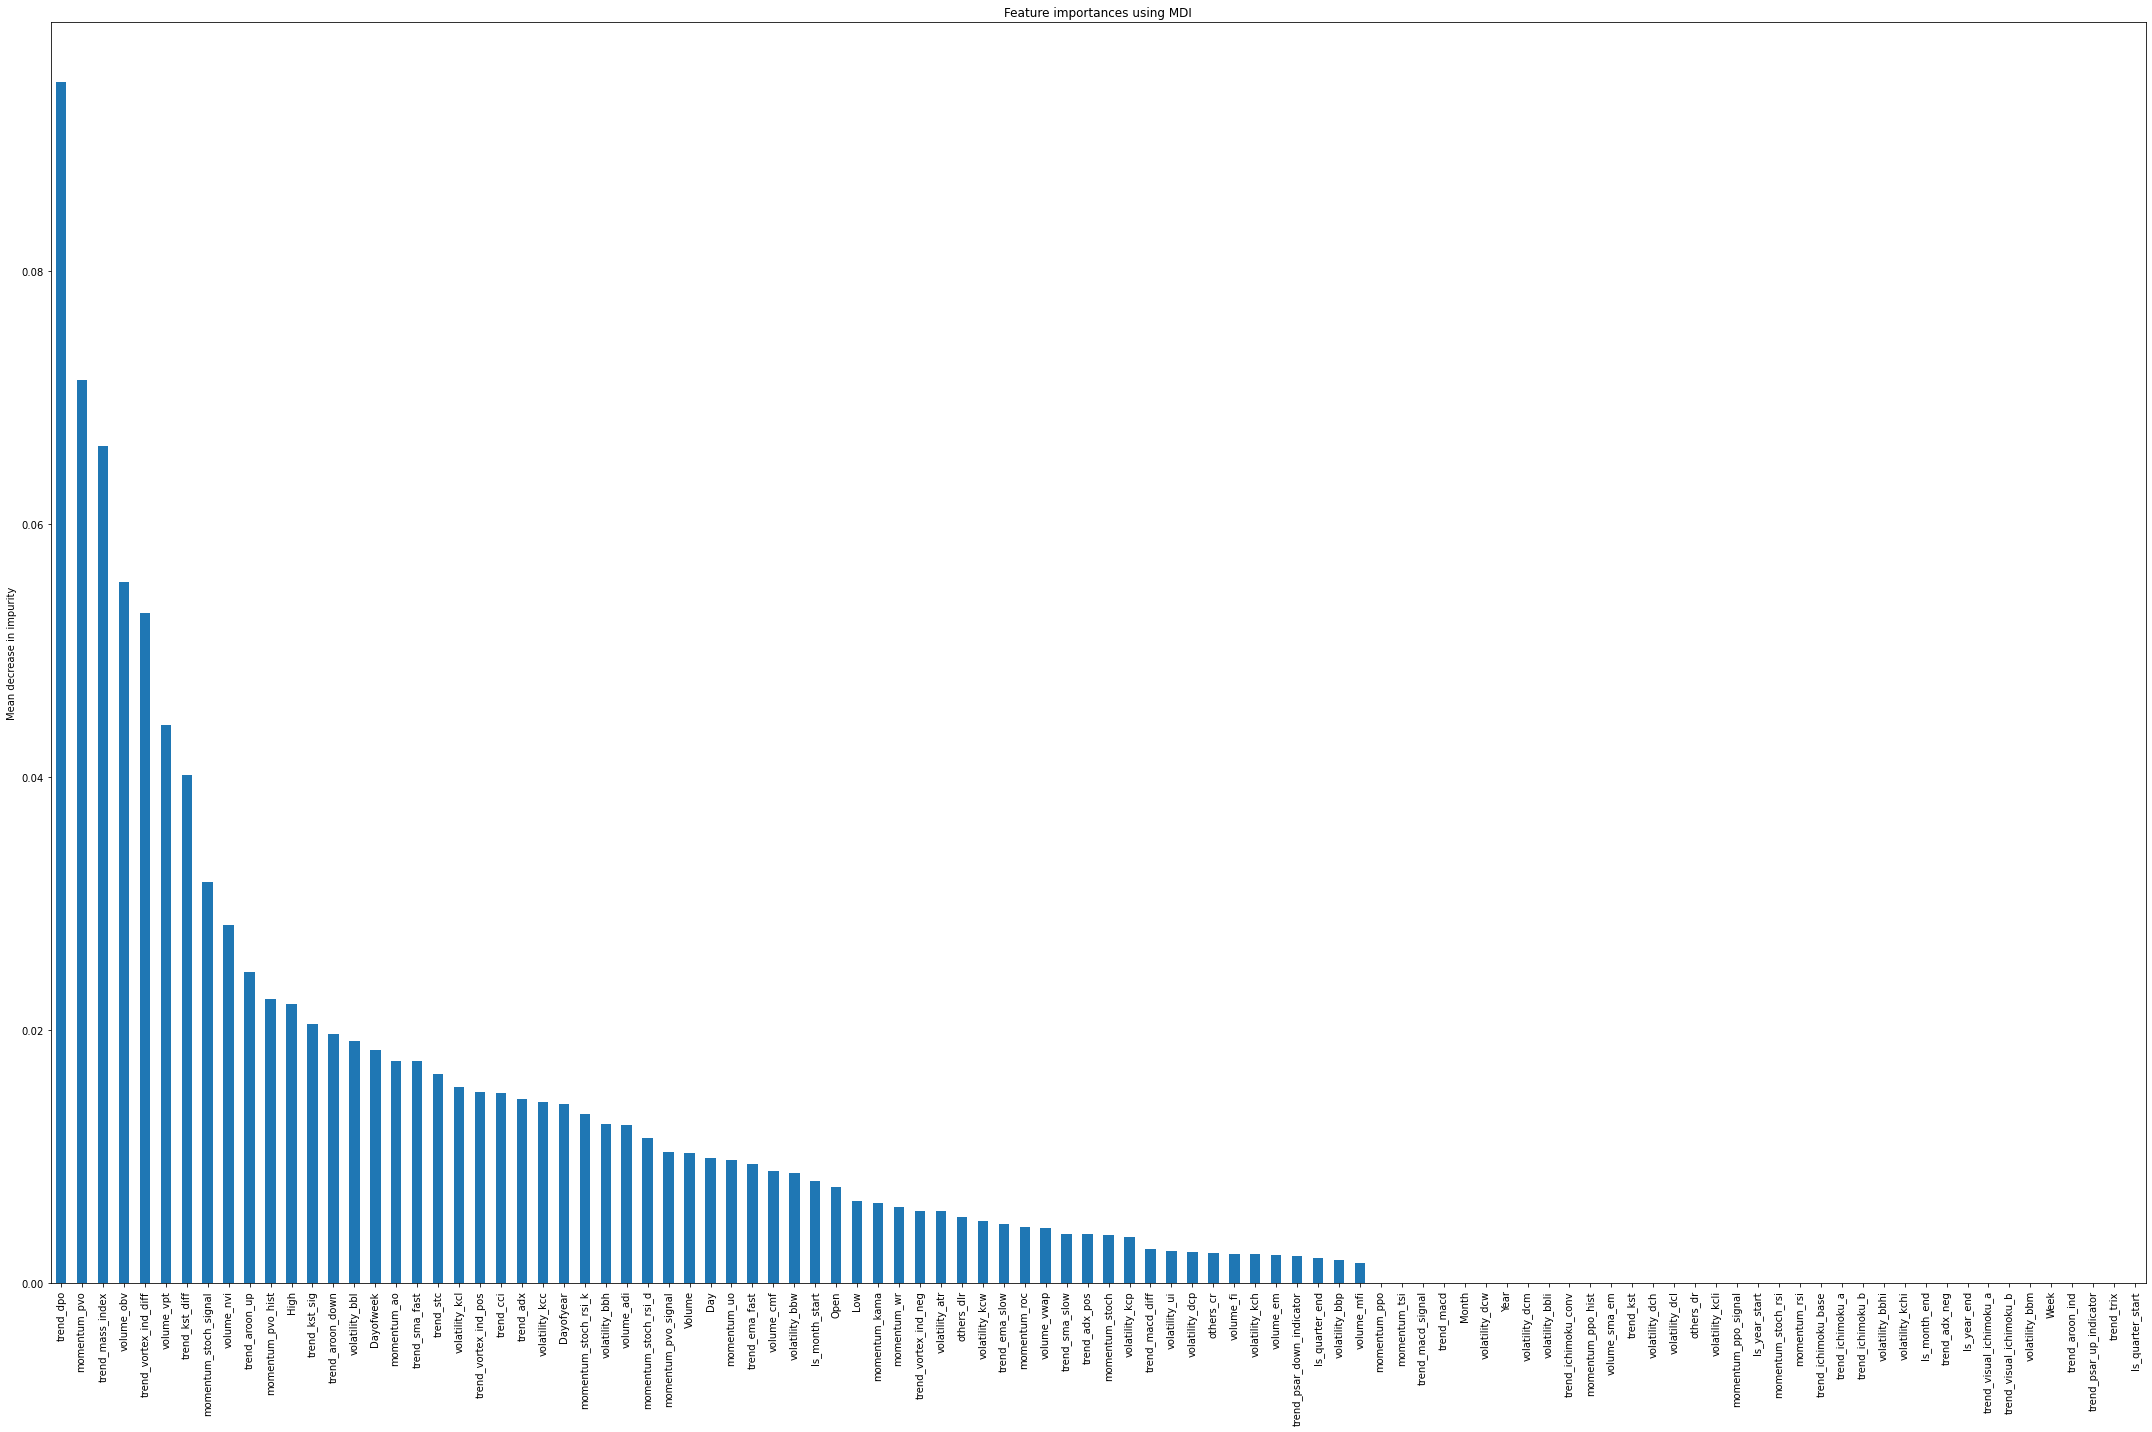

In [13]:
_ = feature_importance(ada_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.077737
momentum_pvo             0.067055
volume_obv               0.053653
volume_nvi               0.050779
trend_kst_diff           0.042664
trend_stc                0.042240
volatility_ui            0.035068
trend_mass_index         0.034684
Open                     0.033381
trend_kst_sig            0.032080
trend_sma_fast           0.031691
momentum_stoch_signal    0.029415
trend_cci                0.029414
High                     0.025719
Dayofweek                0.022351
volume_vwap              0.021265
trend_vortex_ind_pos     0.016857
momentum_stoch_rsi_d     0.016789
volume_vpt               0.016517
momentum_pvo_hist        0.016449
dtype: float64


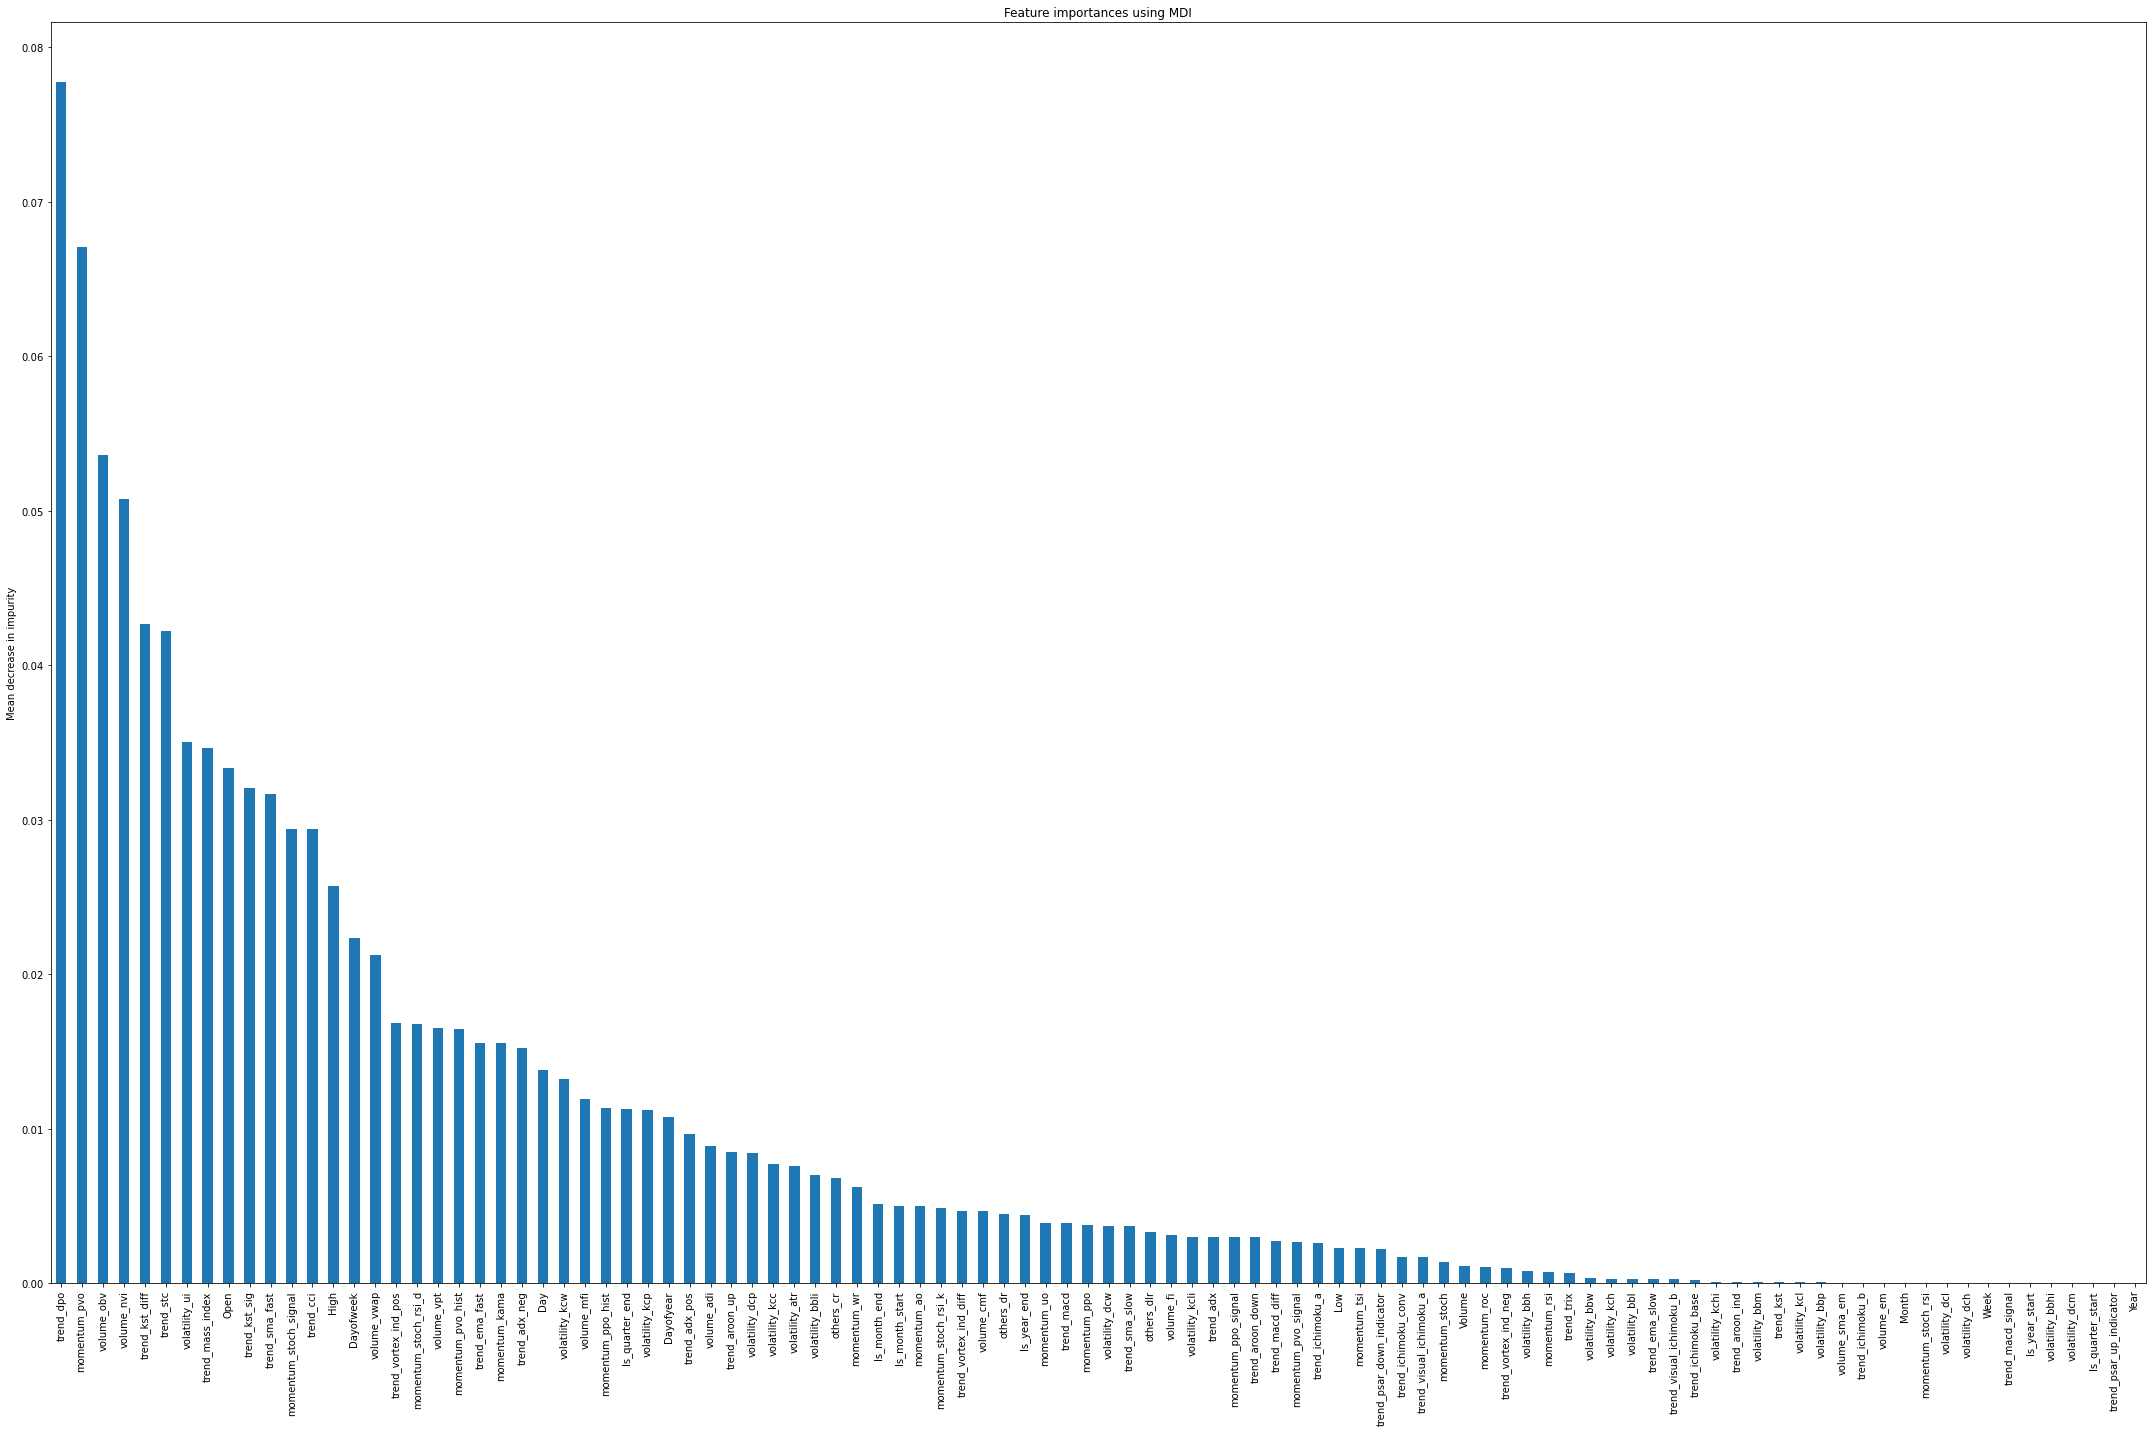

In [14]:
_ = feature_importance(gra_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.064141
momentum_pvo             0.052948
volume_obv               0.040310
trend_mass_index         0.039533
volume_nvi               0.034354
trend_kst_diff           0.031862
High                     0.026753
volume_vpt               0.026716
trend_vortex_ind_diff    0.026190
momentum_stoch_signal    0.022891
trend_stc                0.022701
trend_kst_sig            0.022229
trend_sma_fast           0.021878
Open                     0.021537
trend_cci                0.019001
momentum_pvo_hist        0.018692
volatility_ui            0.017215
Dayofweek                0.016741
volume_vwap              0.015609
trend_vortex_ind_pos     0.015067
dtype: float64


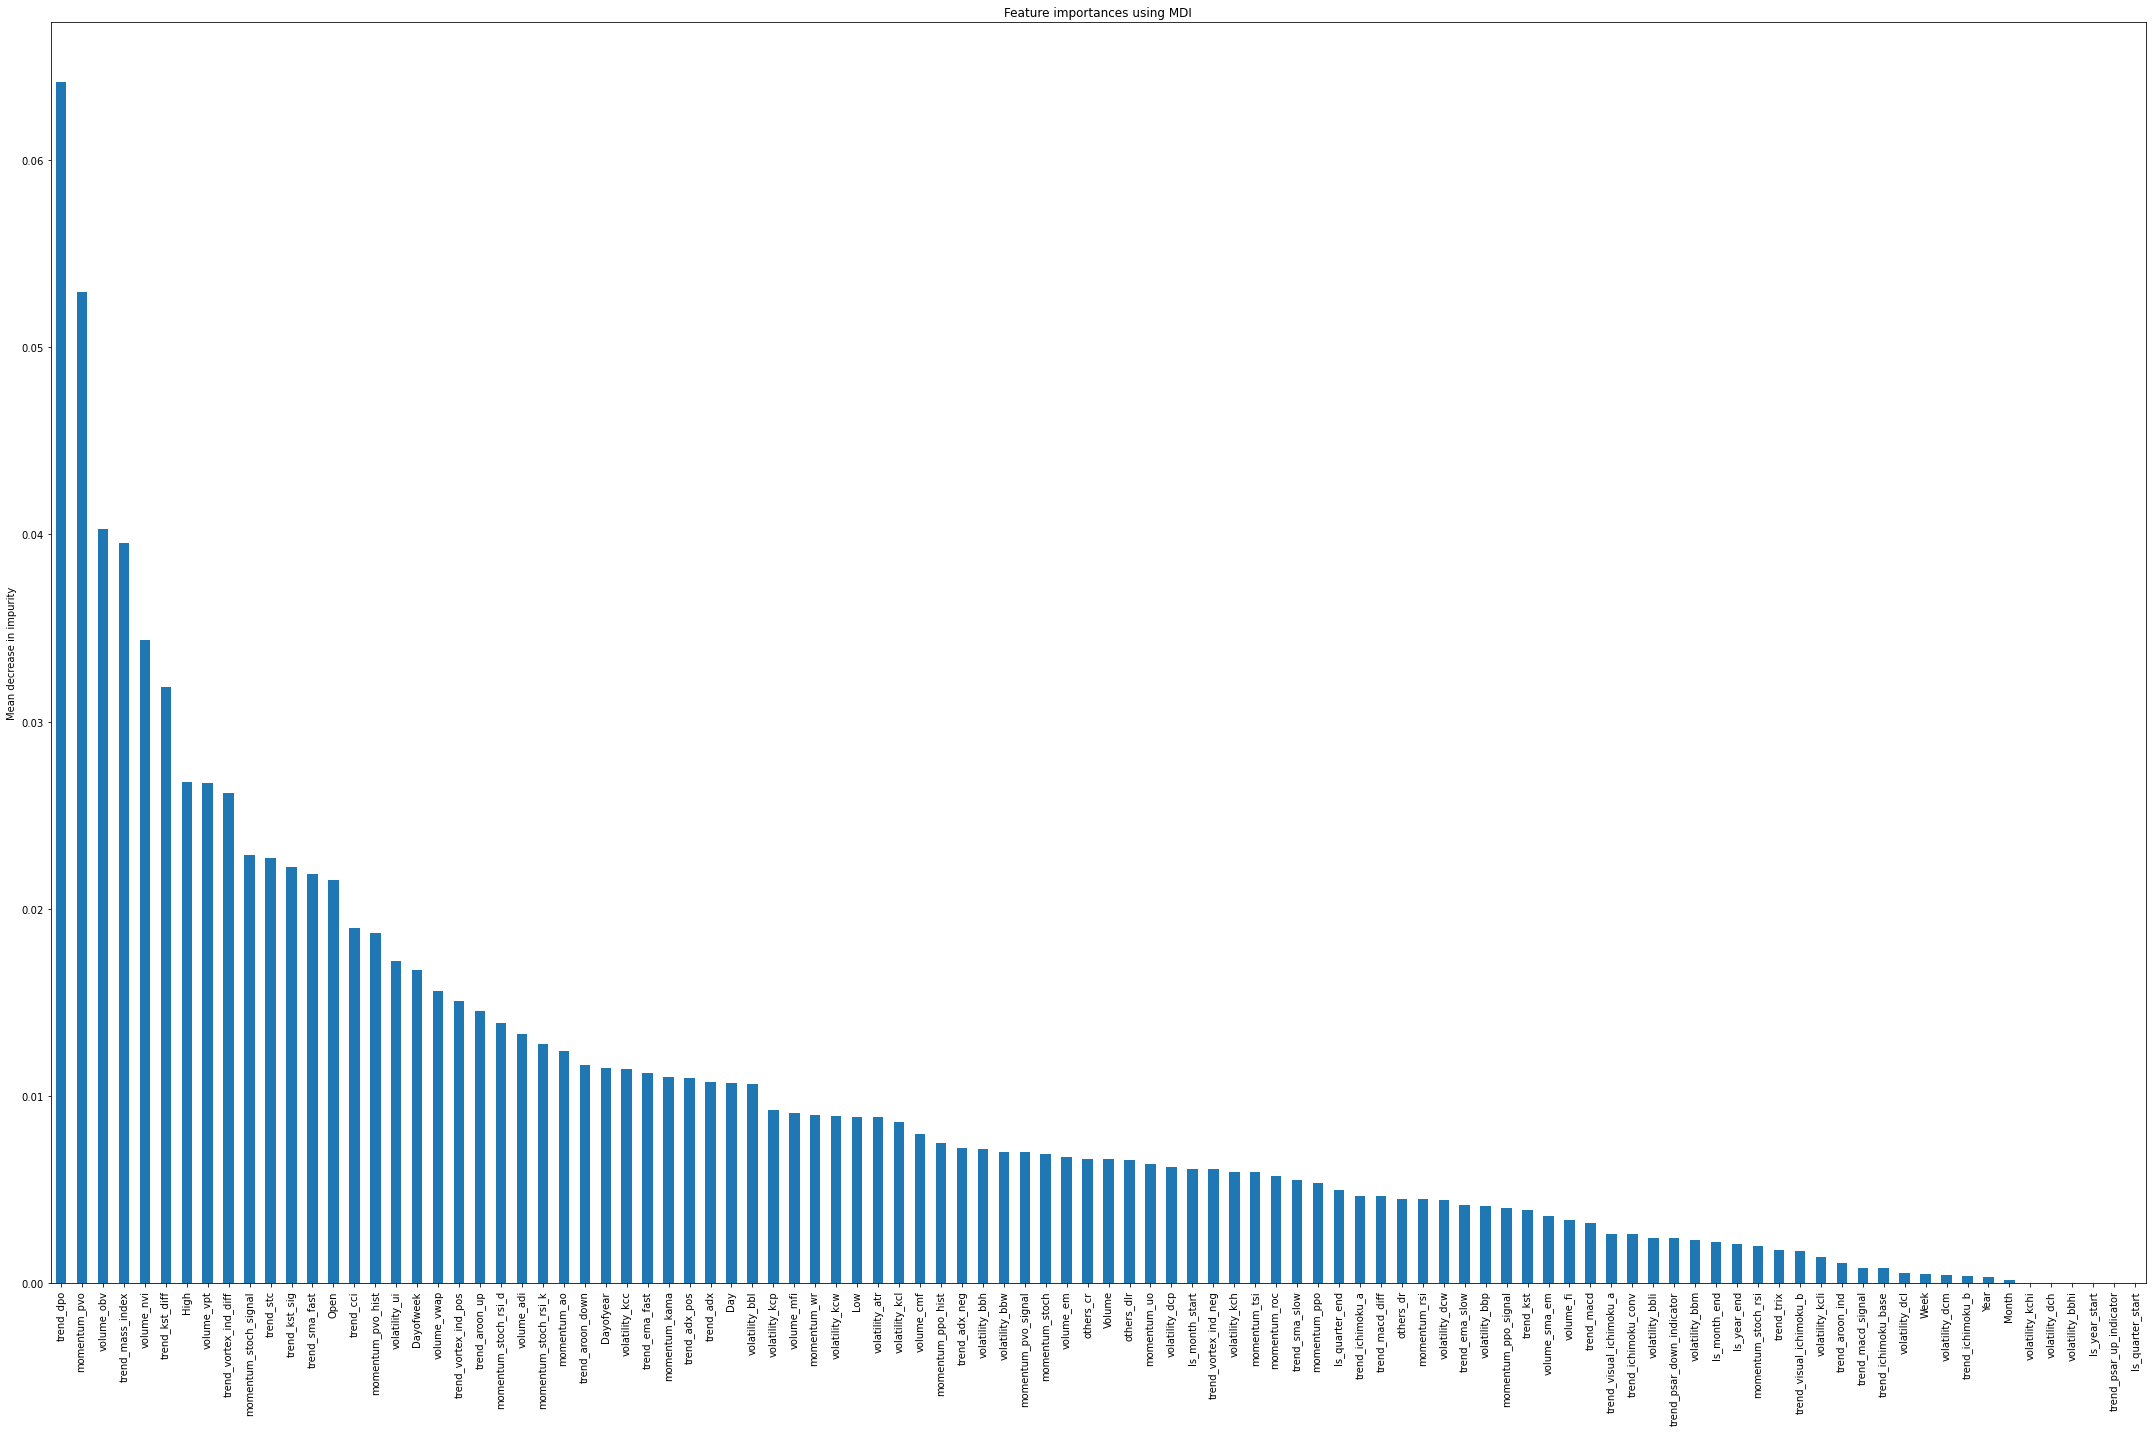

In [15]:
ave_AAPL = (rf_AAPL + ada_AAPL + gra_AAPL) / 3
imp_AAPL = feature_importance(ave_AAPL, columns_AAPL)

## Microsoft

In [16]:
# MSFT : Data with full set of technical features
X_train_MSFT, y_train_MSFT, columns_MSFT = prepare_dataset('data/MSFT_data.csv')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [17]:
rf_MSFT, ada_MSFT, gra_MSFT = sklearn_cross_validation(X_train_MSFT, y_train_MSFT, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.4545454545454546
Mean Accuracy of Adaboost 0.43636363636363634
Mean Accuracy of Gradient Boosting 0.38181818181818183


Top 20 Best Features : 

others_cr               0.099581
momentum_ppo_hist       0.071863
volume_nvi              0.044852
High                    0.039082
Low                     0.030053
trend_adx_pos           0.028732
trend_vortex_ind_pos    0.028466
momentum_roc            0.025896
volatility_bbl          0.025823
trend_macd_signal       0.025619
volatility_kcp          0.024015
volume_adi              0.023869
momentum_pvo_hist       0.023793
trend_adx_neg           0.022583
momentum_rsi            0.022419
trend_cci               0.020382
momentum_wr             0.016936
momentum_pvo            0.016922
volatility_kcc          0.016076
volatility_bbp          0.015040
dtype: float64


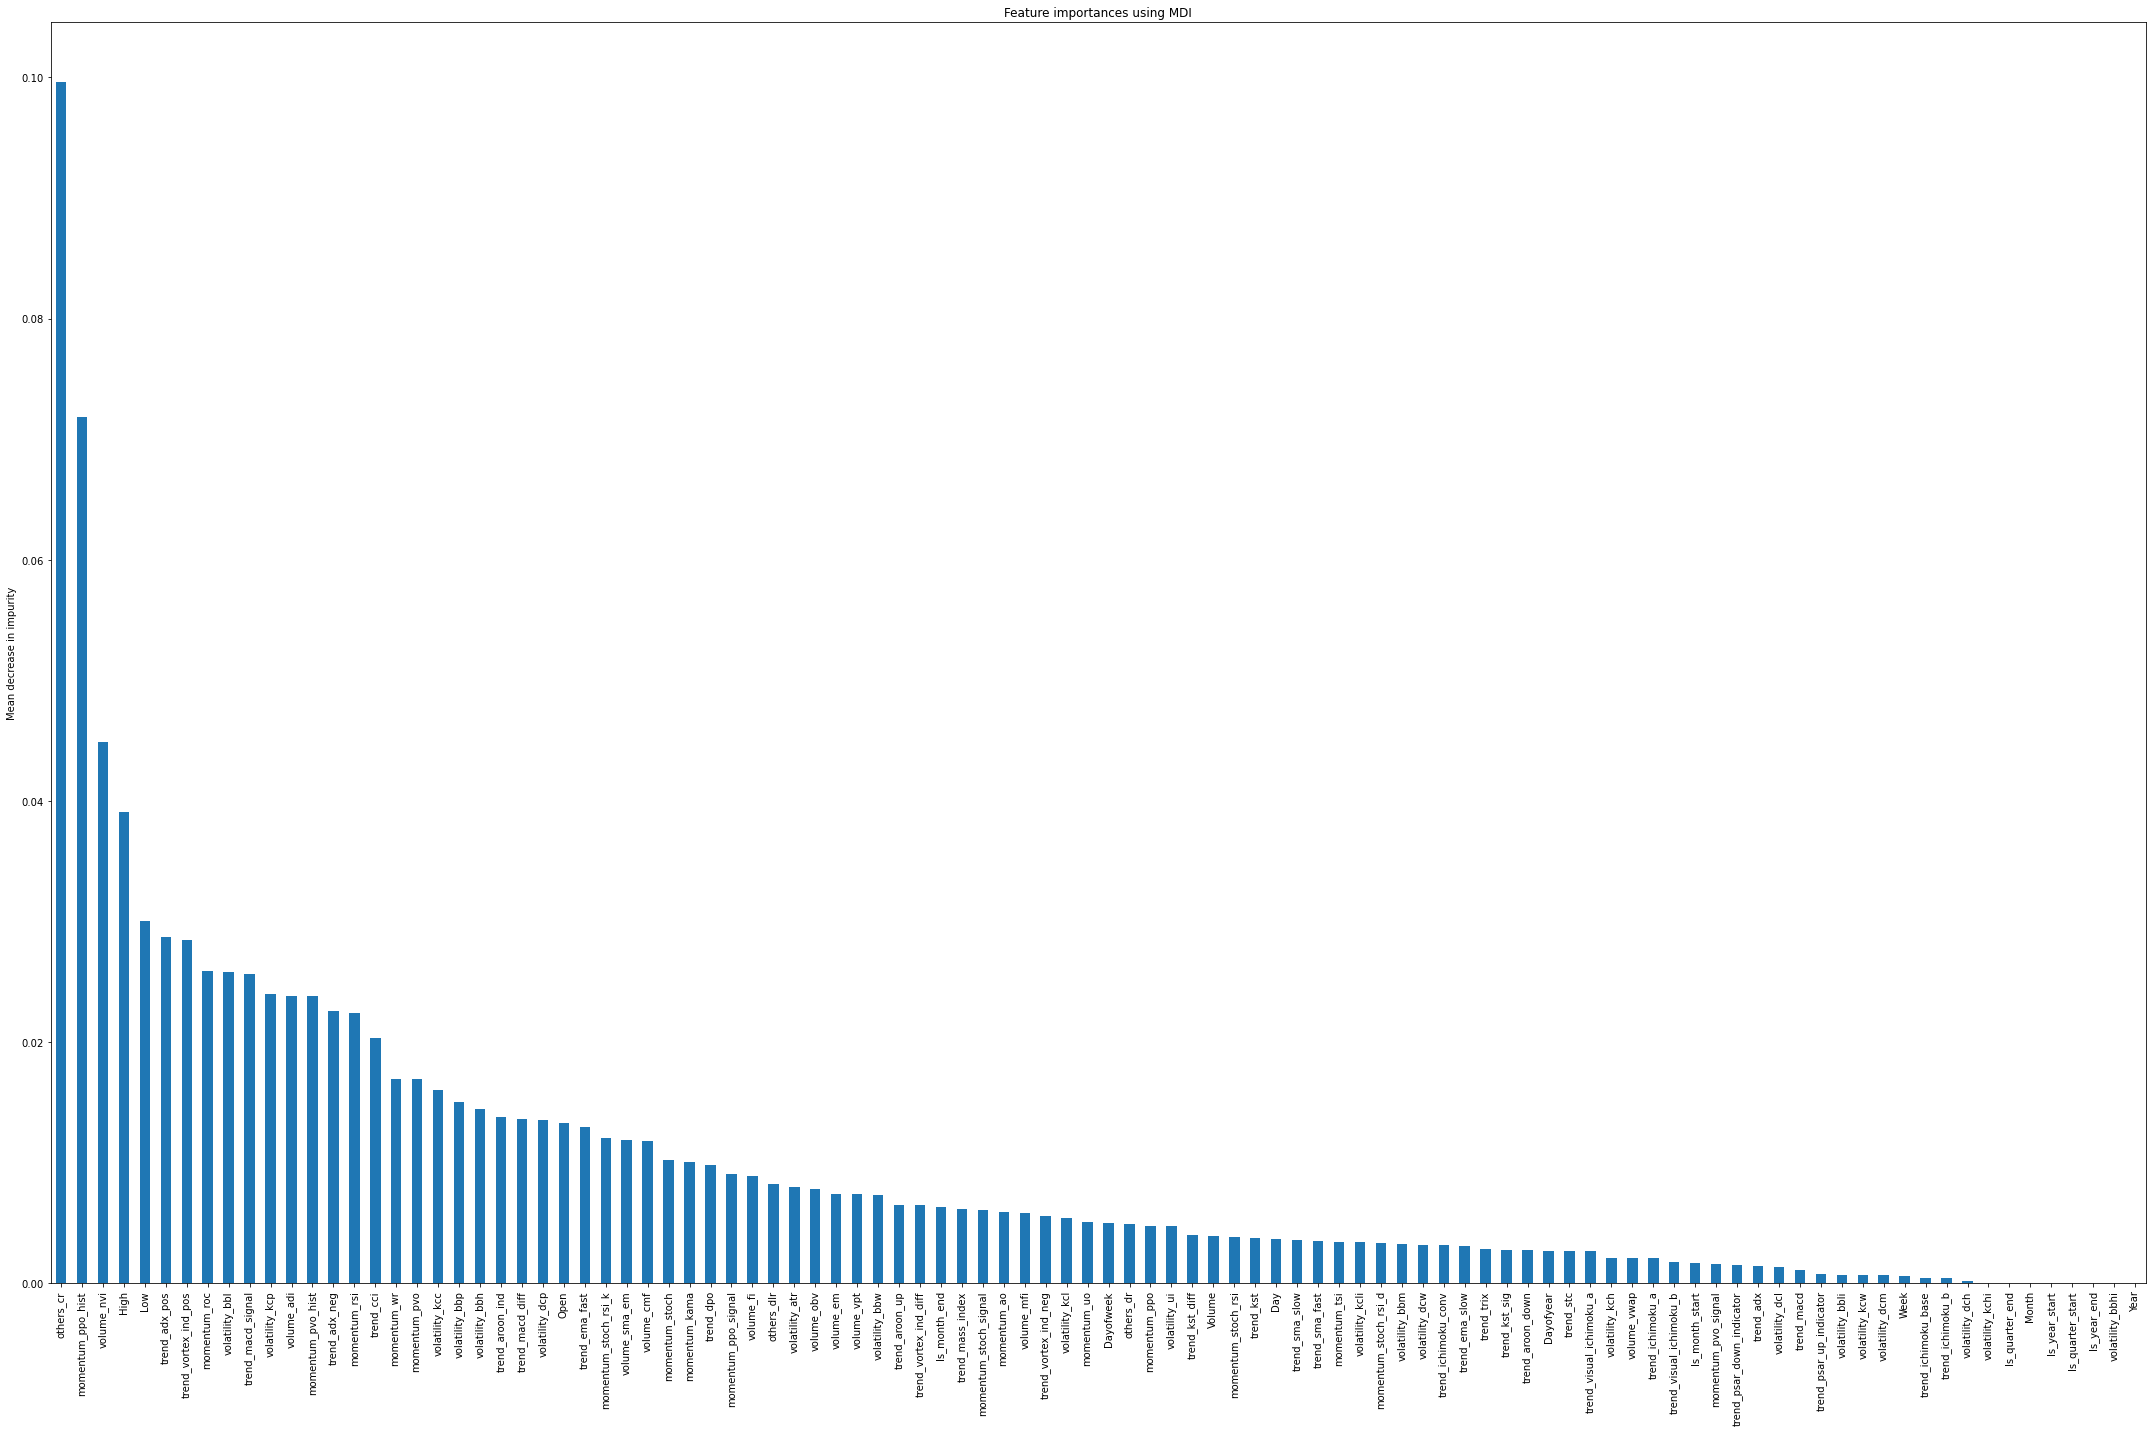

In [18]:
ave_MSFT = (rf_MSFT + ada_MSFT + gra_MSFT) / 3
imp_MSFT = feature_importance(ave_MSFT, columns_MSFT)

## NVDIA

In [19]:
# NVDA : Data with full set of technical features
X_train_NVDA, y_train_NVDA, columns_NVDA = prepare_dataset('data/NVDA_data.csv')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [20]:
rf_NVDA, ada_NVDA, gra_NVDA = sklearn_cross_validation(X_train_NVDA, y_train_NVDA, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.4909090909090909
Mean Accuracy of Adaboost 0.47272727272727266
Mean Accuracy of Gradient Boosting 0.47272727272727266


Top 20 Best Features : 

trend_aroon_ind          0.080282
others_dlr               0.059532
others_cr                0.050165
others_dr                0.048804
volatility_atr           0.039050
momentum_rsi             0.035033
trend_vortex_ind_neg     0.033467
trend_dpo                0.029959
trend_aroon_up           0.029449
Volume                   0.027083
volume_obv               0.022801
trend_mass_index         0.021446
volume_adi               0.020882
momentum_stoch_rsi_k     0.019881
trend_vortex_ind_diff    0.018904
volume_vpt               0.018690
Dayofyear                0.016176
momentum_pvo_hist        0.015551
volatility_kcw           0.015215
Day                      0.014399
dtype: float64


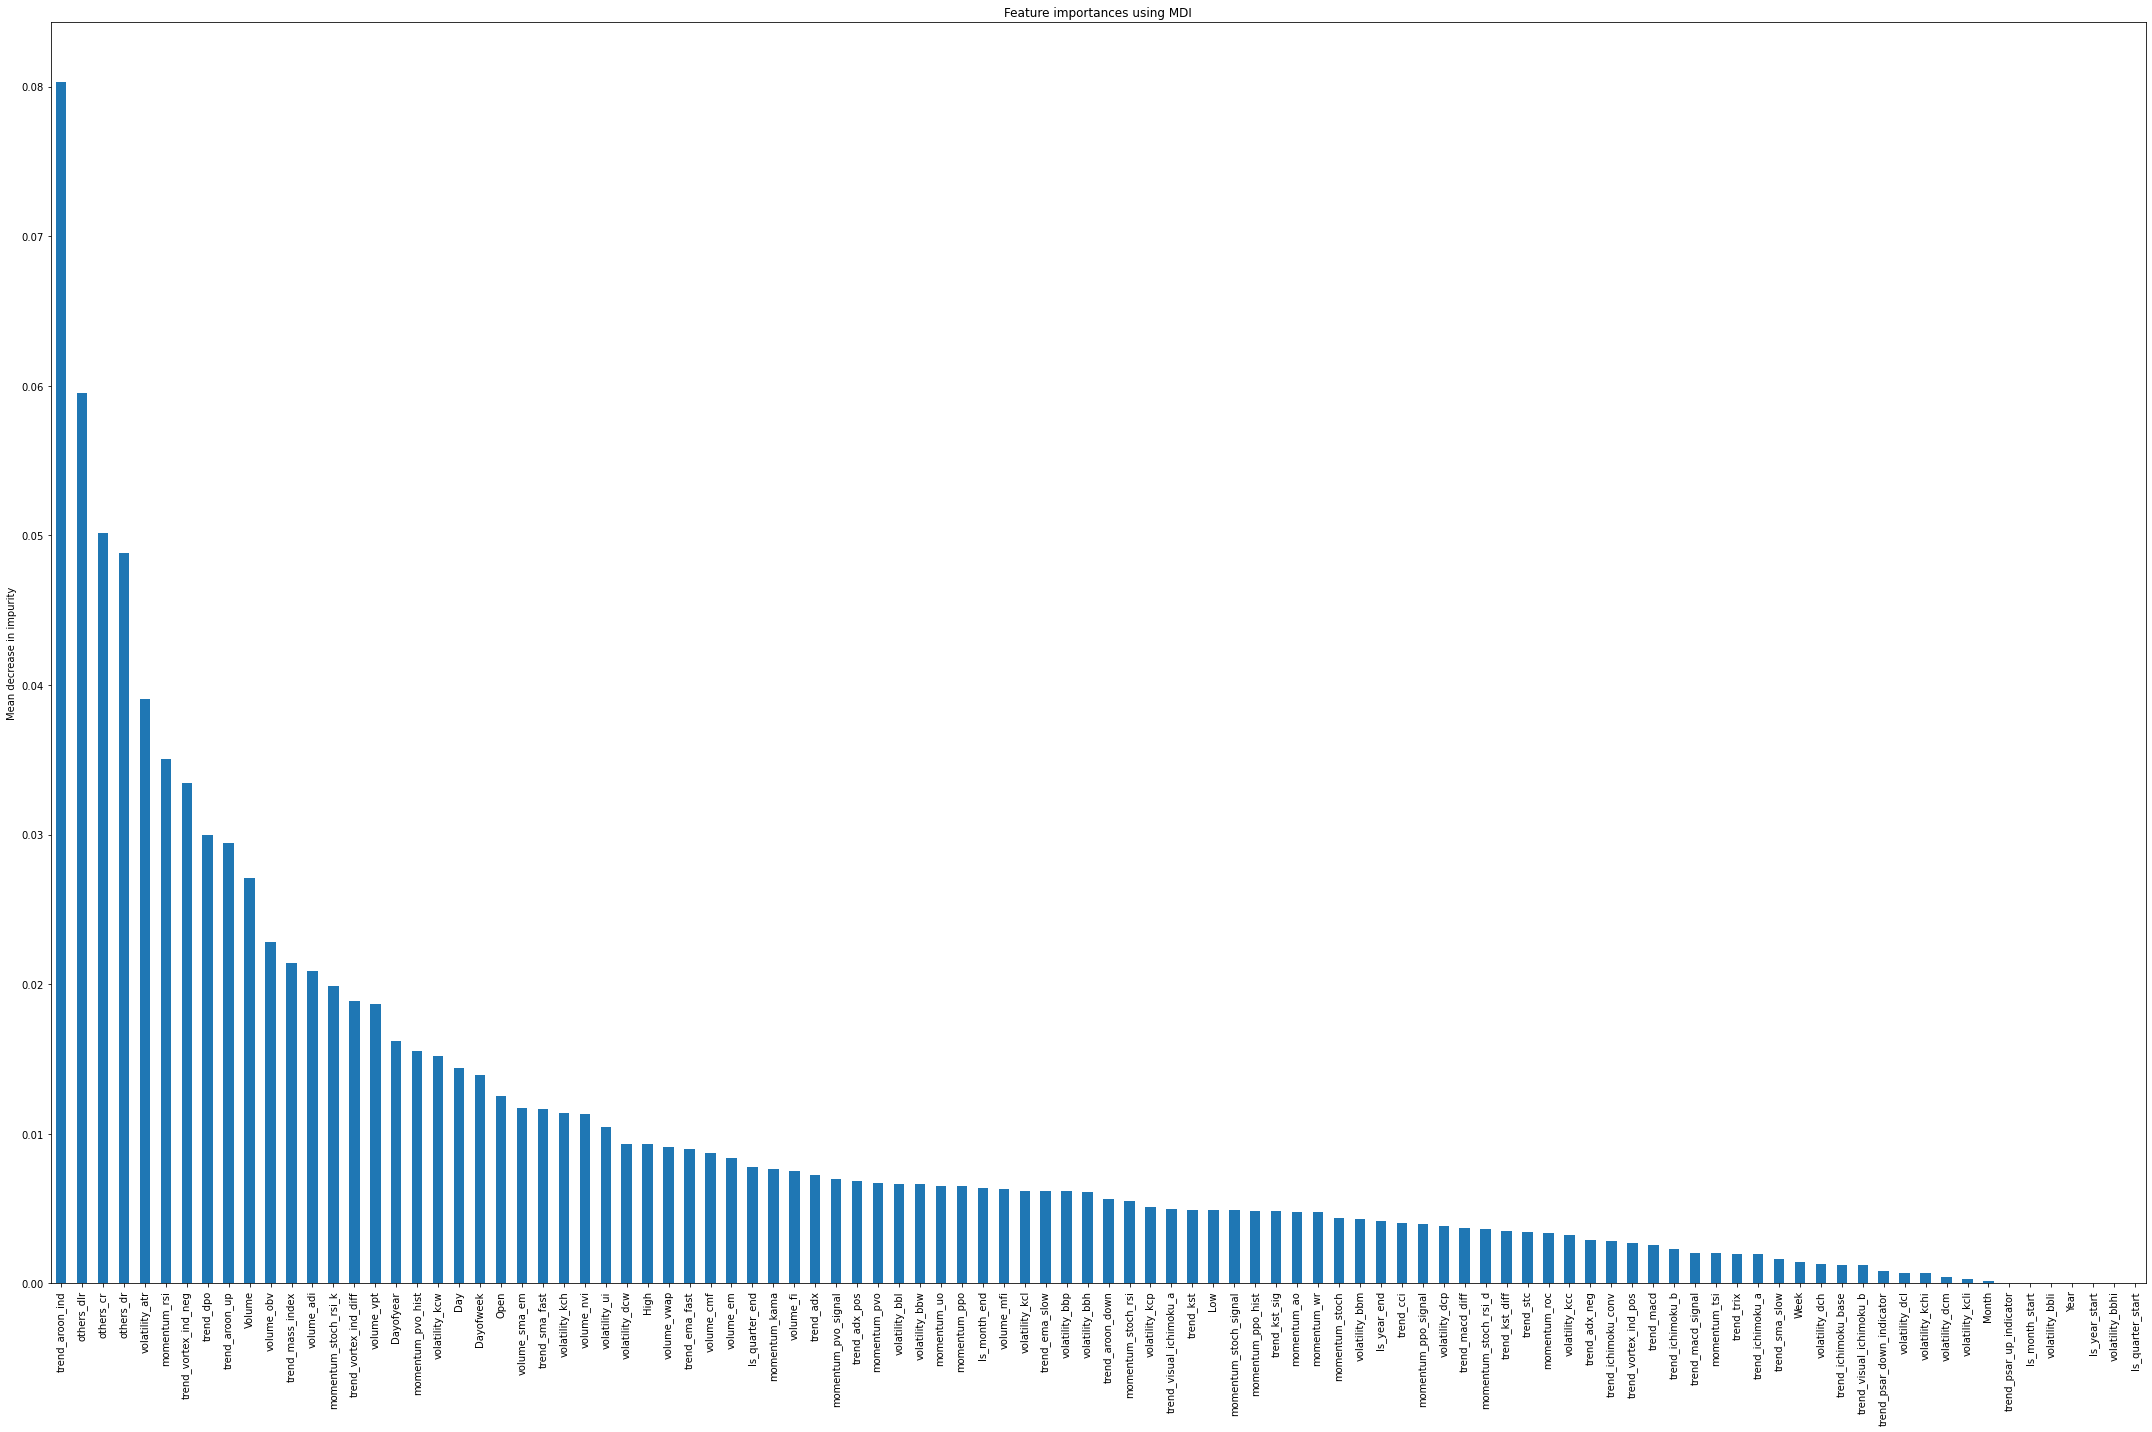

In [21]:
ave_NVDA = (rf_NVDA + ada_NVDA + gra_NVDA) / 3
imp_NVDA = feature_importance(ave_NVDA, columns_NVDA)

## Compare 3 companies feature importance

In [22]:
imp_AAPL.name = "AAPL"
imp_MSFT.name = "MSFT"
imp_NVDA.name = "NVDA"

all_companies = pd.merge(imp_AAPL, imp_MSFT, left_index=True, right_index=True)
all_companies = pd.merge(all_companies, imp_NVDA, left_index=True, right_index=True)

In [23]:
all_companies

,AAPL,MSFT,NVDA
trend_dpo,0.064141,0.009819,0.029959
momentum_pvo,0.052948,0.016922,0.006689
volume_obv,0.040310,0.007811,0.022801
trend_mass_index,0.039533,0.006146,0.021446
volume_nvi,0.034354,0.044852,0.011293
...,...,...,...
volatility_dch,0.000001,0.000170,0.001299
volatility_bbhi,0.000000,0.000000,0.000000
Is_year_start,0.000000,0.000000,0.000000
trend_psar_up_indicator,0.000000,0.000743,0.000050


<AxesSubplot:>

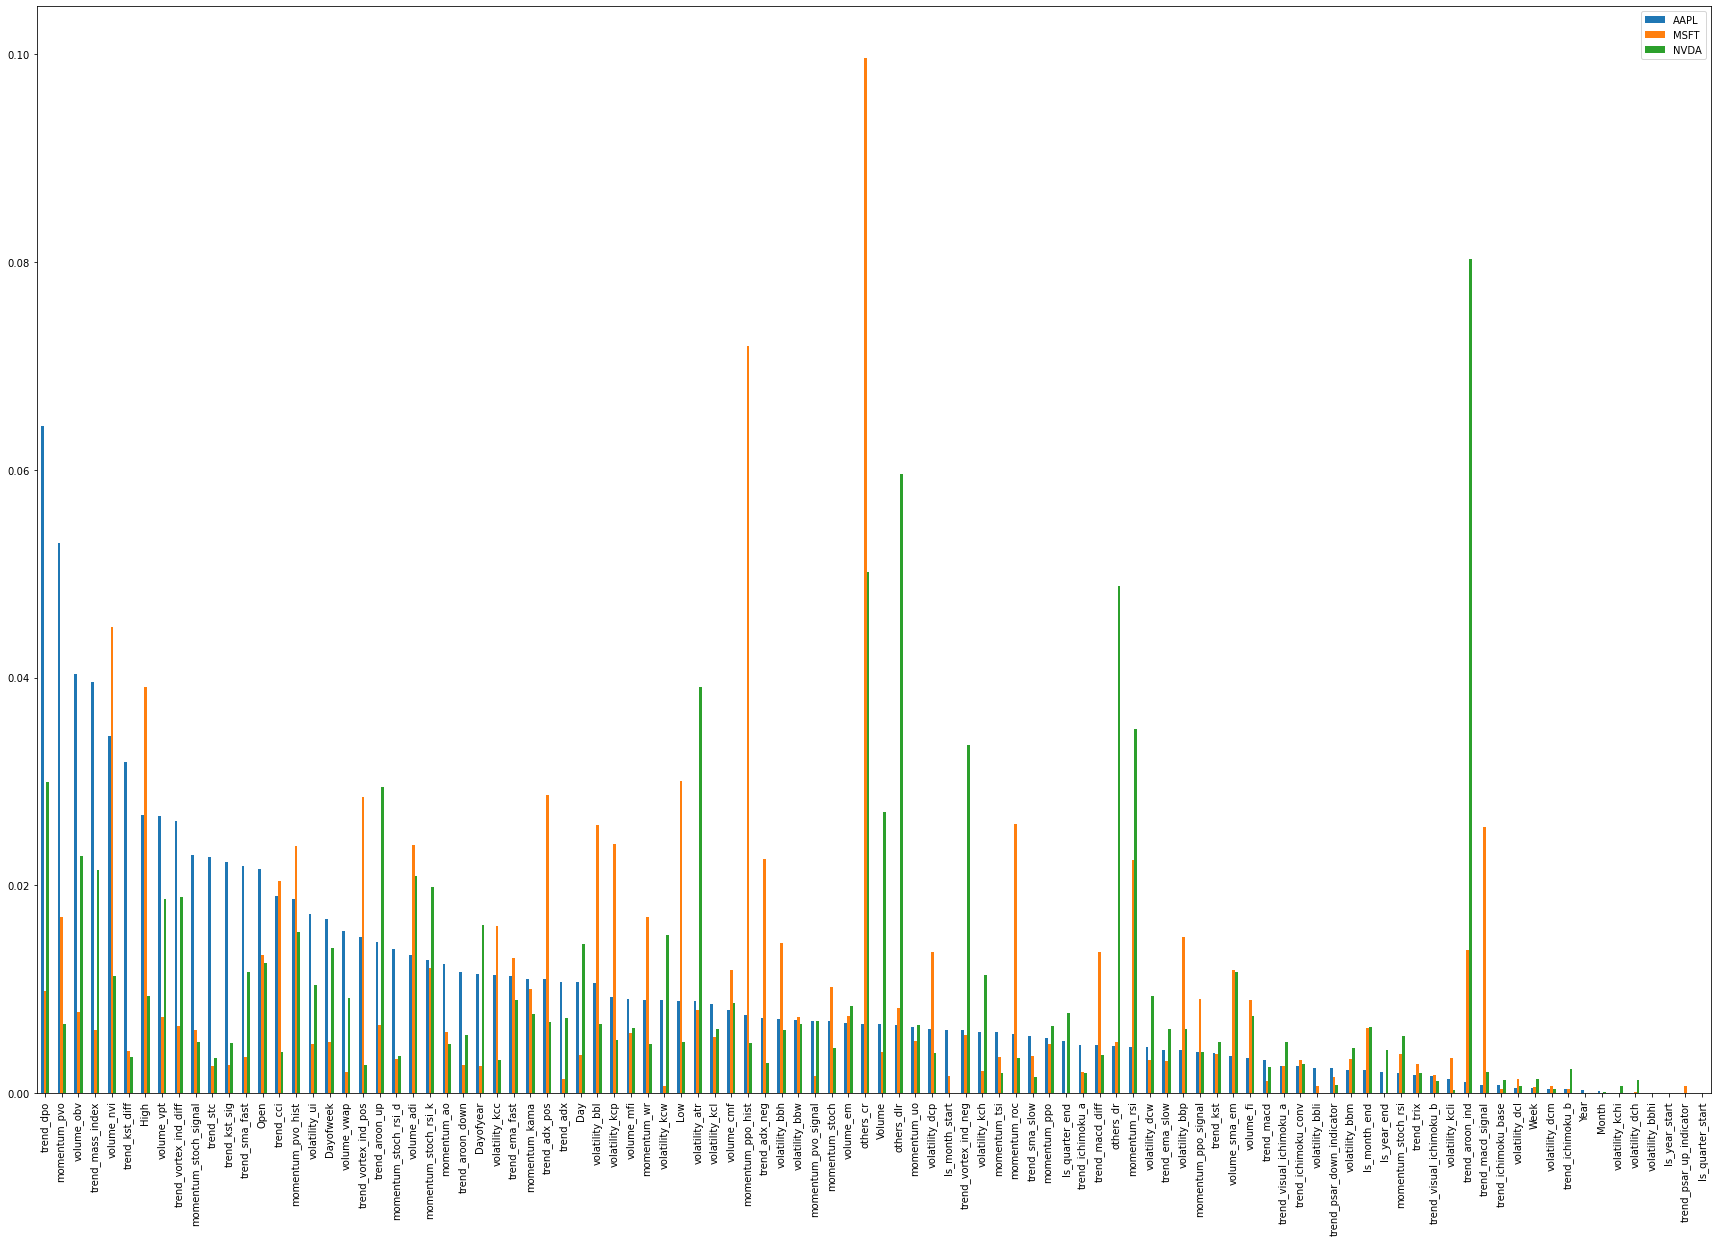

In [24]:
all_companies.plot(y=["AAPL", "MSFT", "NVDA"], kind="bar", figsize=(30,20), legend=True)

## Add Apple RoBERTa

In [25]:
# AAPL : Data with full set of technical features + sentiment score
X_train_AAPLs, y_train_AAPLs, columns_AAPLs = prepare_dataset(sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.52
Mean Accuracy of Adaboost 0.52
Mean Accuracy of Gradient Boosting 0.6
Top 20 Best Features : 

trend_ema_slow           0.096883
Volume                   0.091716
others_dr                0.076386
volatility_bbh           0.049833
others_dlr               0.048482
bearish                  0.046790
trend_dpo                0.031273
volume_adi               0.029277
volume_fi                0.021085
trend_aroon_down         0.018938
bullish                  0.018727
Day                      0.017207
momentum_kama            0.016456
momentum_stoch_signal    0.015941
momentum_uo              0.014920
volume_em                0.014857
volatility_dcw           0.014028
volatility_kcp           0.013750
volatility_bbp           0.013344
volume_vpt               0.013317
dtype: float64


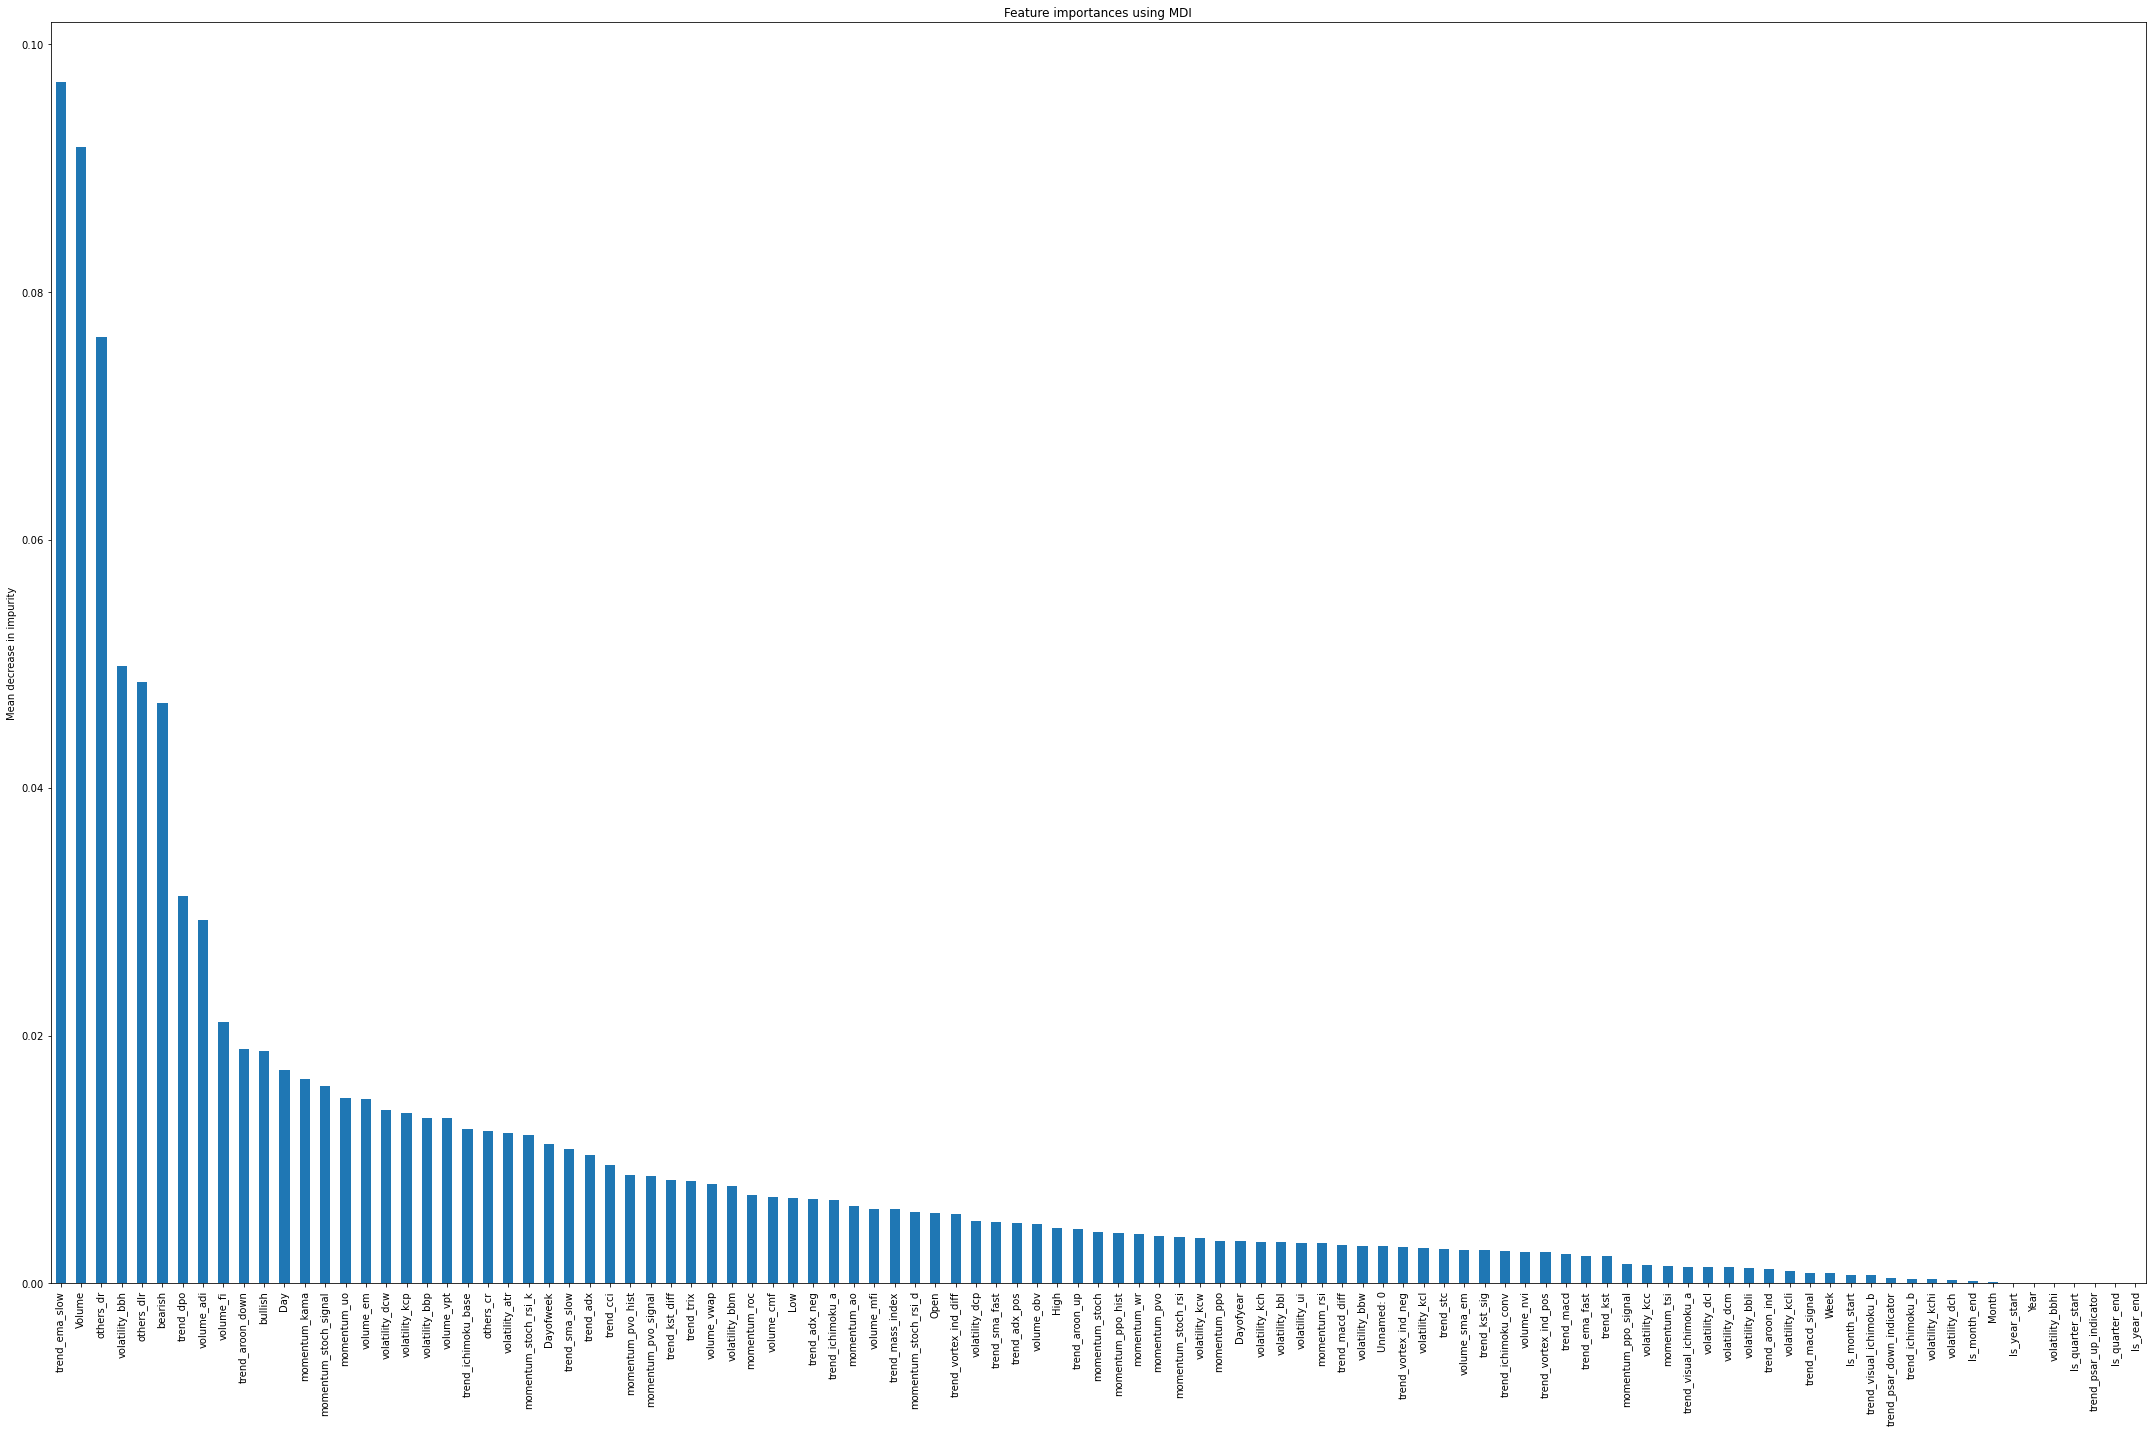

In [26]:
rf_AAPLs, ada_AAPLs, gra_AAPLs = sklearn_cross_validation(X_train_AAPLs, y_train_AAPLs, 5, verbose=True, plot=False)
ave_AAPLs = (rf_AAPLs + ada_AAPLs + gra_AAPLs) / 3
imp_AAPLs = feature_importance(ave_AAPLs, columns_AAPLs)

## Add Microsoft RoBERTa

In [27]:
# MSFT : Data with full set of technical features + sentiment score
X_train_MSFTs, y_train_MSFTs, columns_MSFTs = prepare_dataset(path = 'data/MSFT_data.csv', s_path = 'data/MSFT_byday_RoBERTa.csv', sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.58
Mean Accuracy of Adaboost 0.62
Mean Accuracy of Gradient Boosting 0.6
Top 20 Best Features : 

trend_cci               0.132582
trend_dpo               0.062578
others_cr               0.049912
momentum_stoch_rsi_k    0.040776
trend_adx_neg           0.034075
others_dlr              0.031831
others_dr               0.030192
volume_vpt              0.028319
Volume                  0.023693
momentum_ppo            0.021608
volatility_bbp          0.020013
trend_aroon_up          0.019539
volatility_ui           0.019132
volume_fi               0.017406
volatility_kcp          0.017346
volume_obv              0.016029
momentum_wr             0.015126
trend_macd              0.014630
Open                    0.014303
bearish                 0.014033
dtype: float64


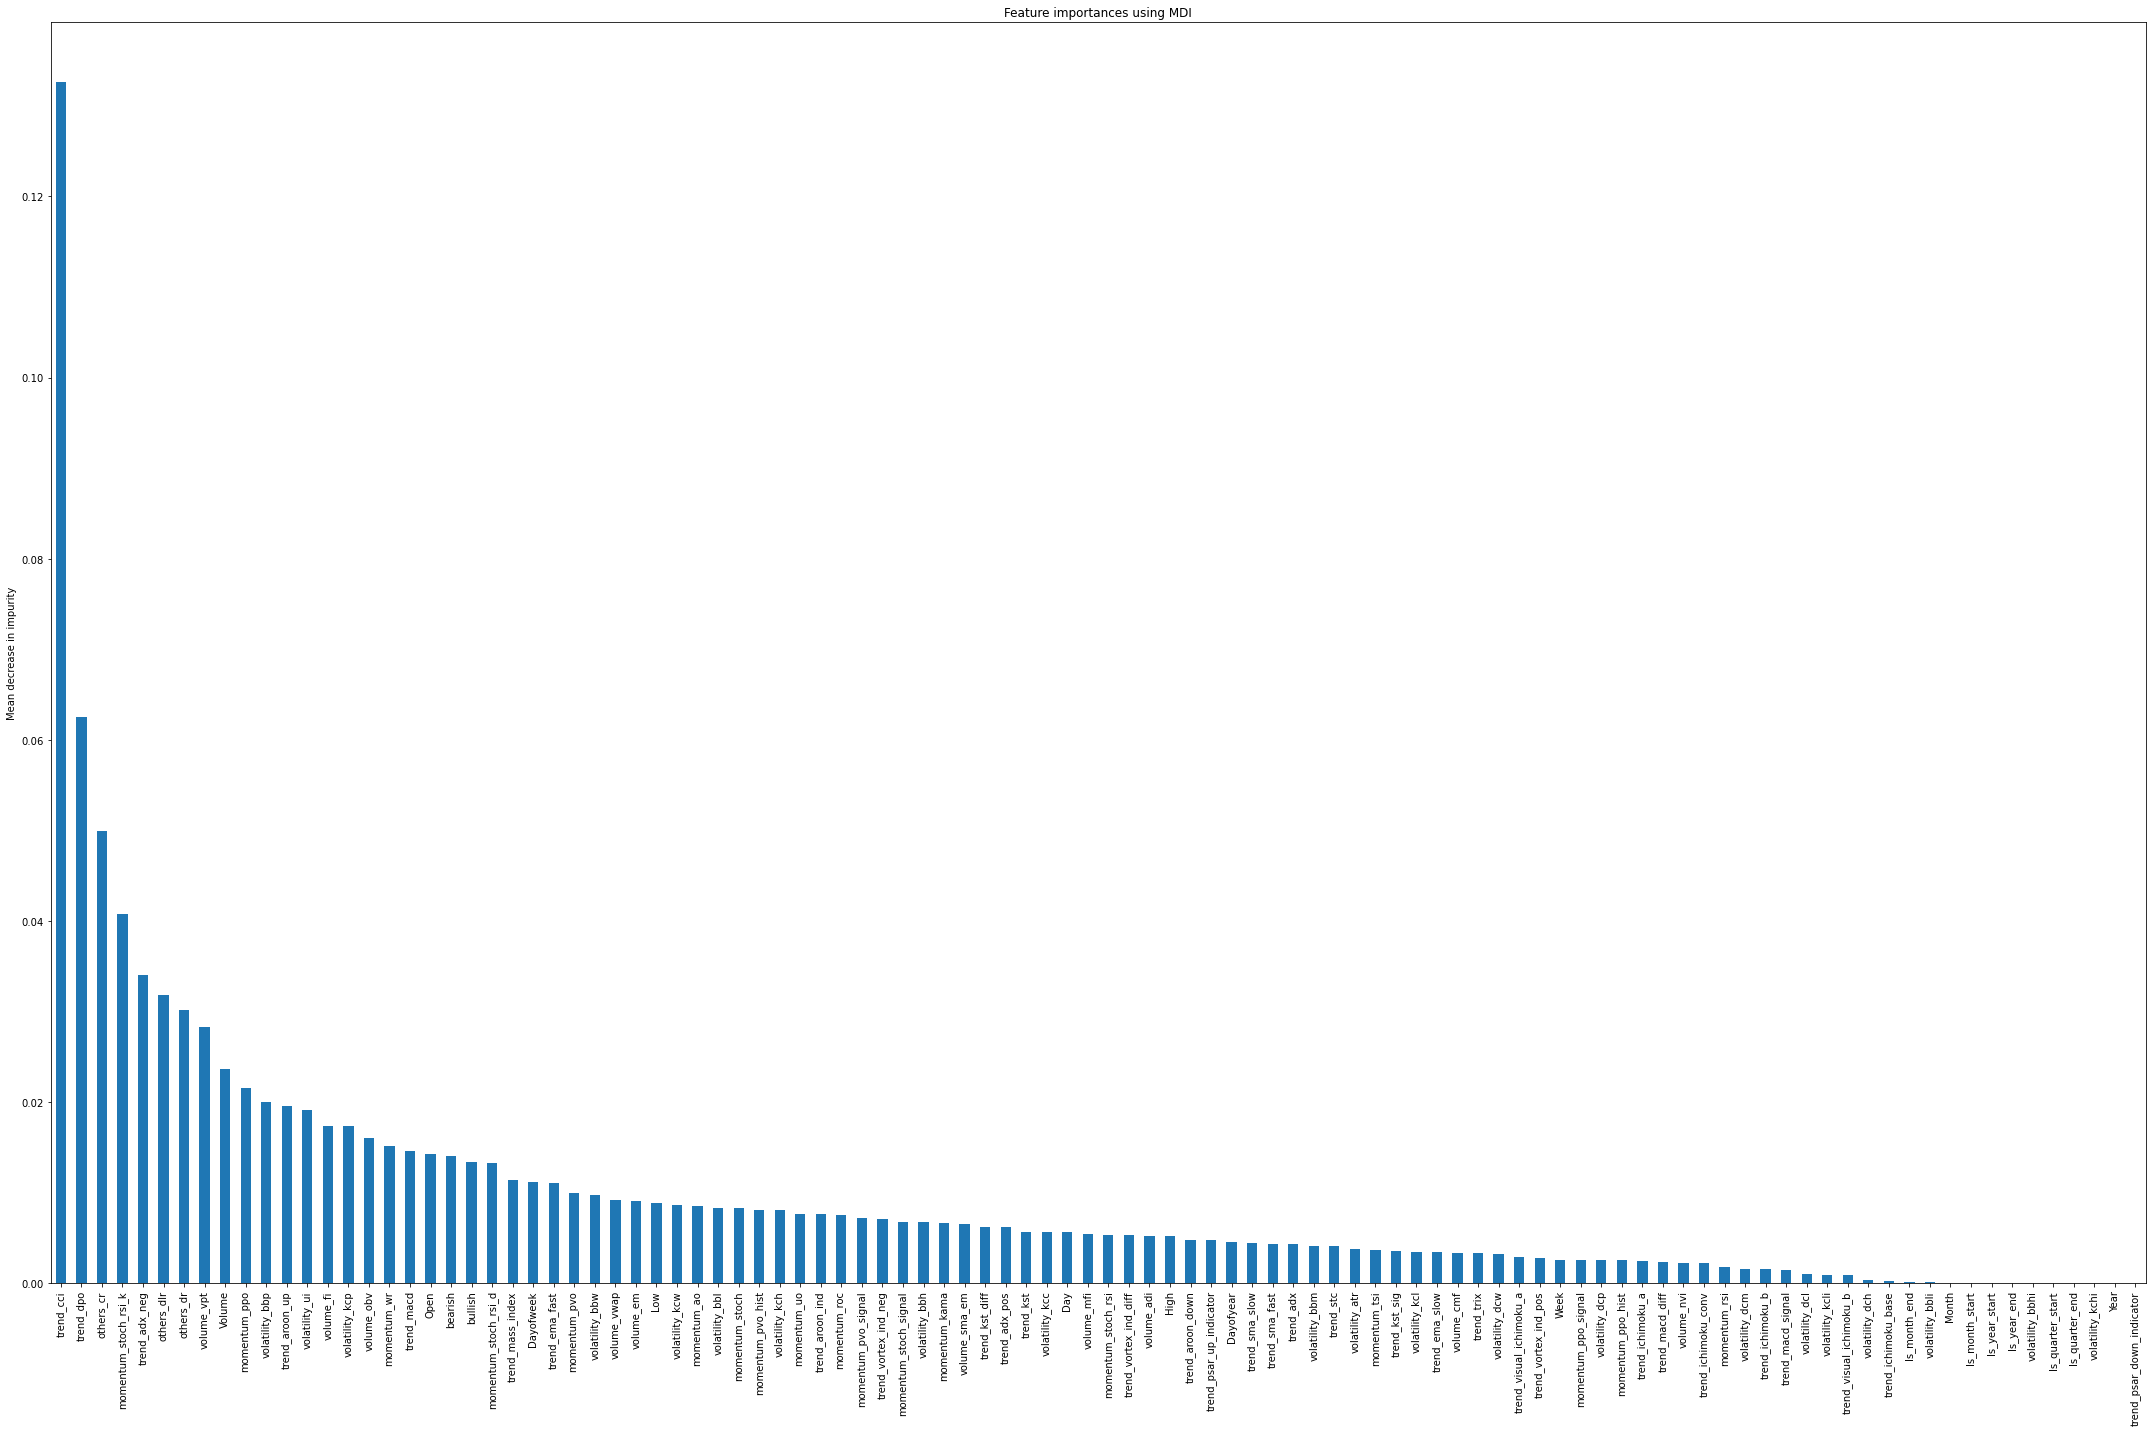

In [28]:
rf_MSFTs, ada_MSFTs, gra_MSFTs = sklearn_cross_validation(X_train_MSFTs, y_train_MSFTs, 5, verbose=True, plot=False)
ave_MSFTs = (rf_MSFTs + ada_MSFTs + gra_MSFTs) / 3
imp_MSFTs = feature_importance(ave_MSFTs, columns_MSFTs)

## Add NVDIA RoBERTa

In [29]:
# NVDA : Data with full set of technical features + sentiment score
X_train_NVDAs, y_train_NVDAs, columns_NVDAs = prepare_dataset(path = 'data/NVDA_data.csv', s_path = 'data/NVDA_byday_RoBERTa.csv', sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.6199999999999999
Mean Accuracy of Adaboost 0.6199999999999999
Mean Accuracy of Gradient Boosting 0.6199999999999999
Top 20 Best Features : 

volatility_bbh           0.108872
momentum_stoch_signal    0.063309
momentum_stoch_rsi_k     0.042364
Dayofweek                0.040285
bearish                  0.039176
volatility_atr           0.037206
volume_em                0.036328
trend_ichimoku_b         0.034829
momentum_stoch_rsi_d     0.033139
bullish                  0.028472
volume_vpt               0.026247
trend_dpo                0.024616
volume_cmf               0.022030
momentum_roc             0.018206
volume_mfi               0.018061
momentum_pvo             0.017979
trend_vortex_ind_diff    0.016820
volume_obv               0.016679
momentum_ao              0.015910
trend_vortex_ind_neg     0.014280
dtype: float64


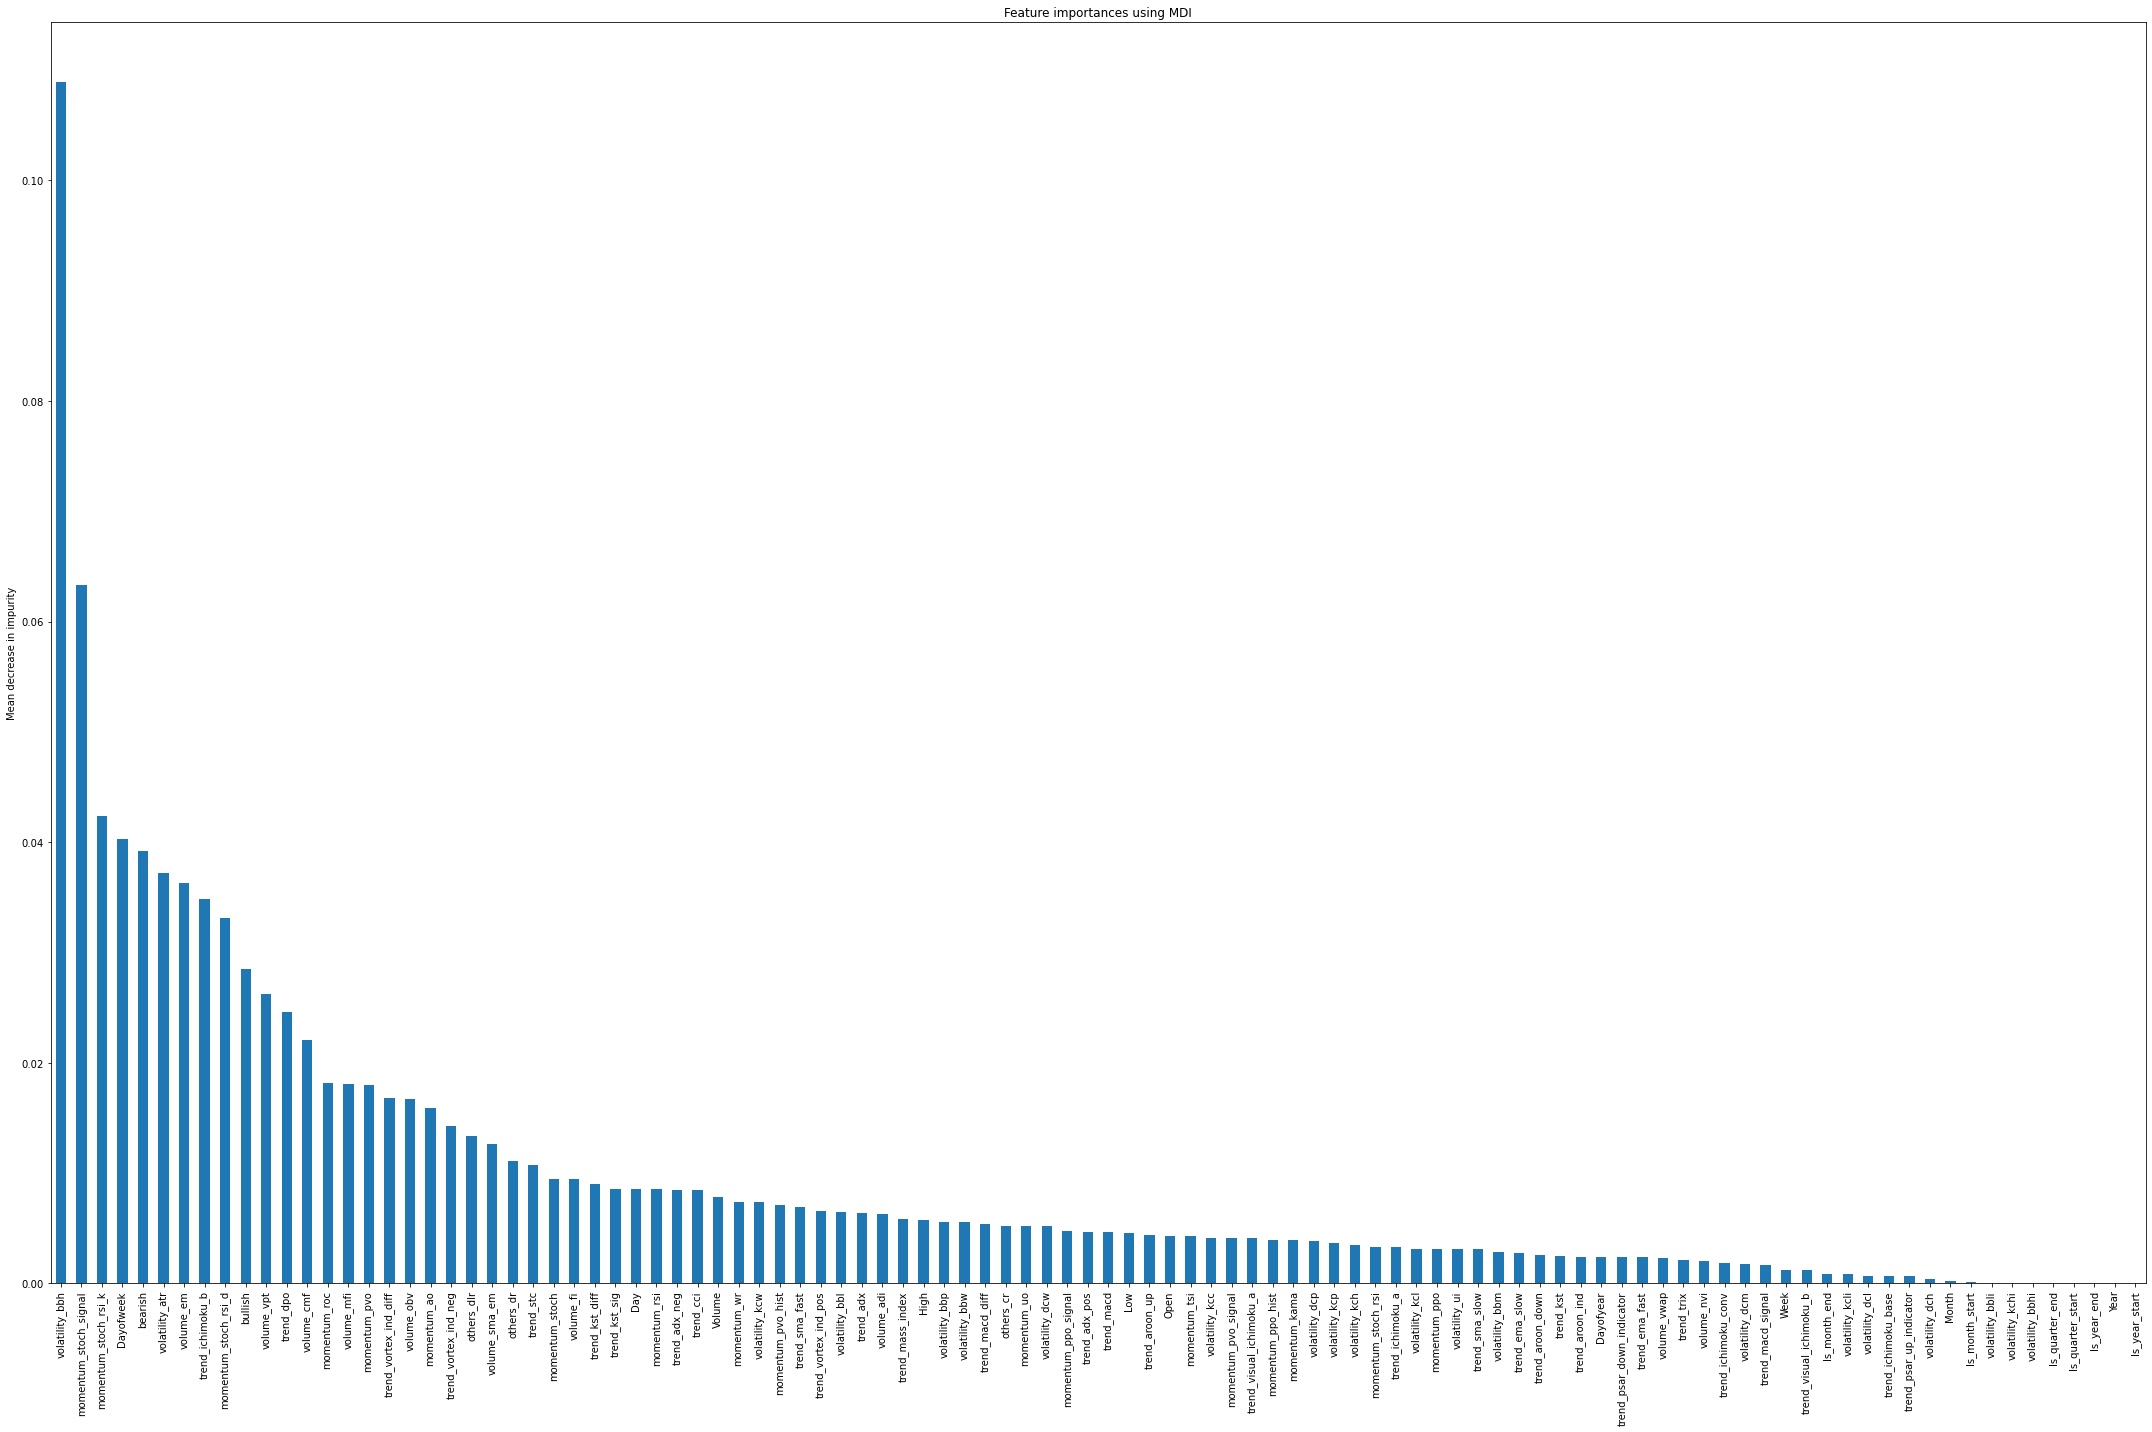

In [30]:
rf_NVDAs, ada_NVDAs, gra_NVDAs = sklearn_cross_validation(X_train_NVDAs, y_train_NVDAs, 5, verbose=True, plot=False)
ave_NVDAs = (rf_NVDAs + ada_NVDAs + gra_NVDAs) / 3
imp_NVDAs = feature_importance(ave_NVDAs, columns_NVDAs)

## Compare 3 companies feature importance with RoBERTa

In [31]:
imp_AAPLs.name = "AAPL"
imp_MSFTs.name = "MSFT"
imp_NVDAs.name = "NVDA"

all_companies_s = pd.merge(imp_AAPLs, imp_MSFTs, left_index=True, right_index=True)
all_companies_s = pd.merge(all_companies_s, imp_NVDAs, left_index=True, right_index=True)

<AxesSubplot:>

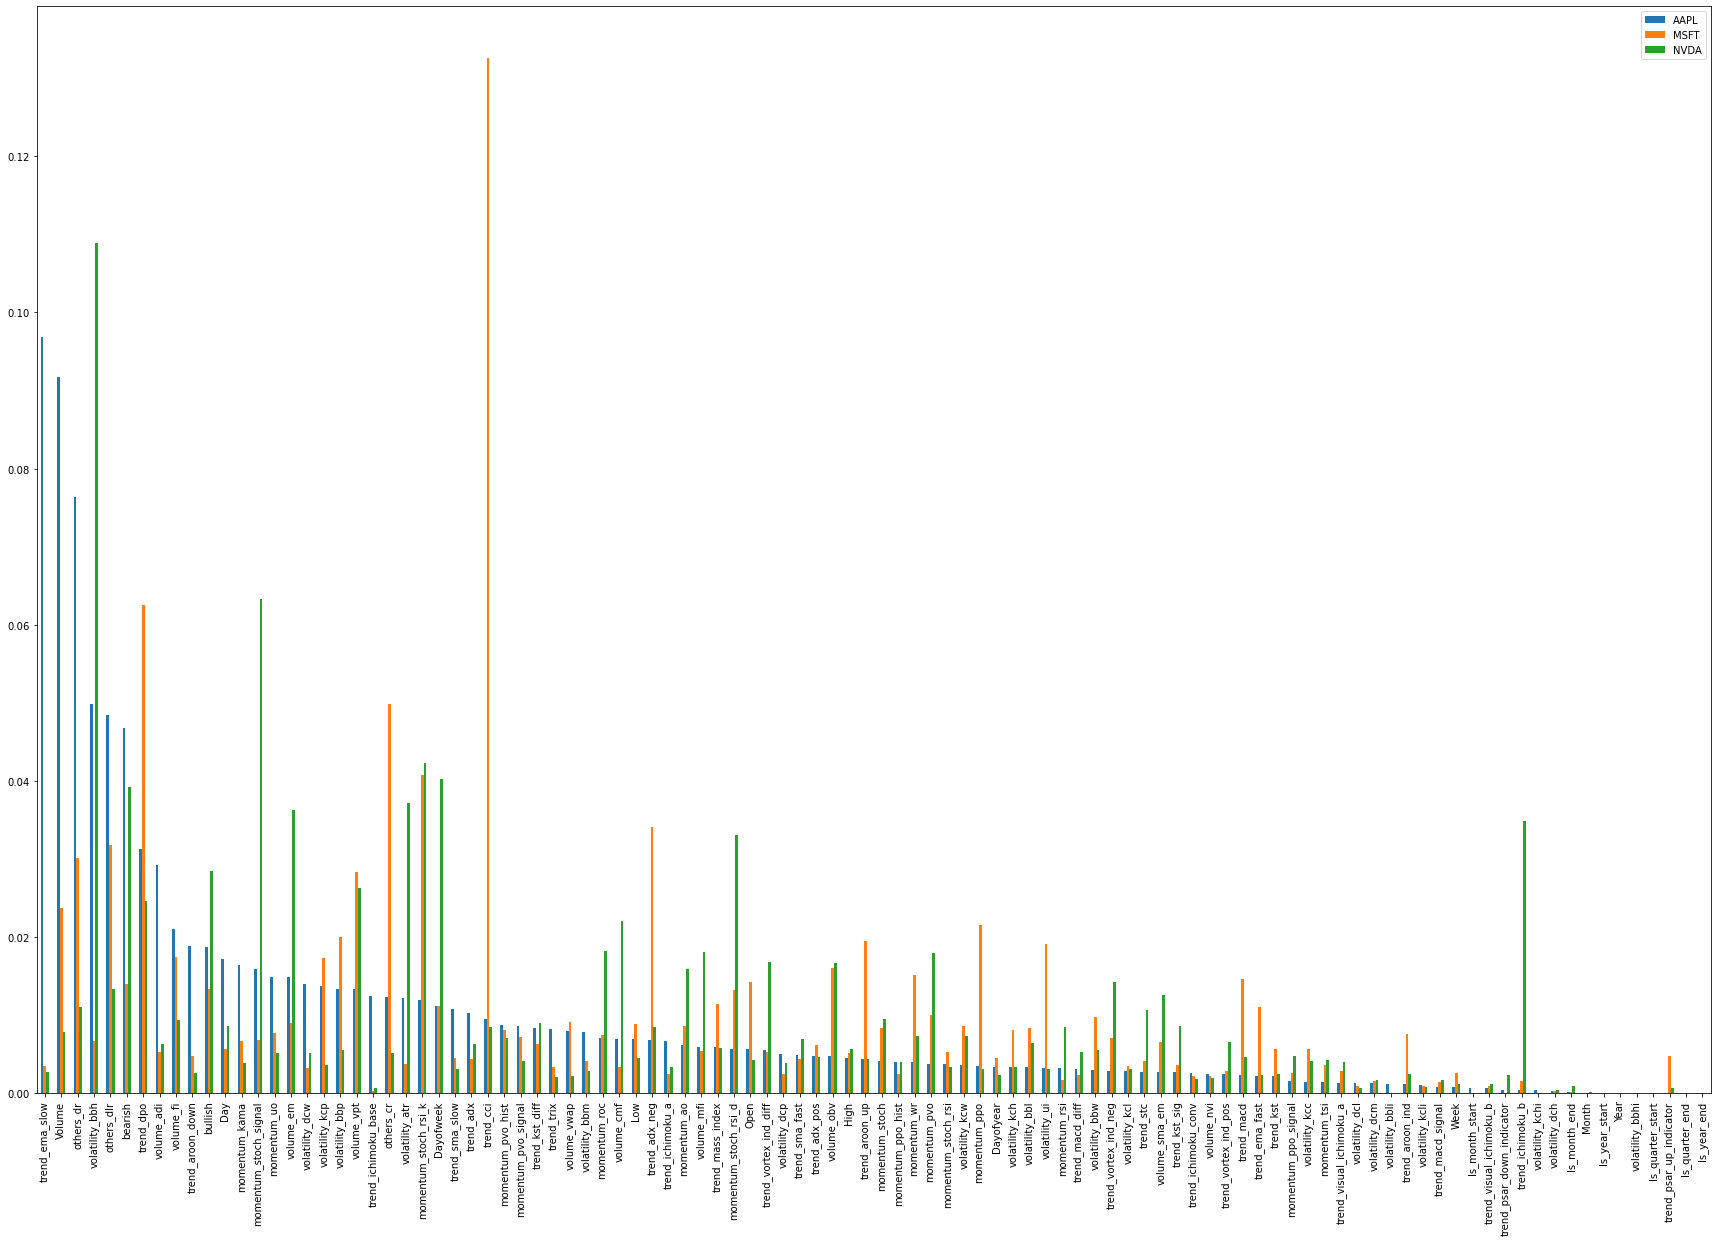

In [32]:
all_companies_s.plot(y=["AAPL", "MSFT", "NVDA"], kind="bar", figsize=(30,20), legend=True)